---
# Poisson Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import KFold
from itertools import product
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("NSFG_2022_2023_FemRespPUFData.csv")
print(df.shape)
df.head()

(5586, 1912)


,CaseID,RSCRAGE,RSCRNINF,RSCRHISP,RSCRRACE,FTFMODE,DEVICE_TYPE,AGE_R,AGESCRN,HISP,...,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,CMFIVYR,YEAR,QUARTER,PHASE1,PHASE2,PHASE3
0,96064,29,5,5,3,2,Mobile,29,29,5,...,1474,1441,1429,1417,1426,2,4,1,0,0
1,96066,18,5,1,4,2,PC,18,18,1,...,1471,1441,1429,1417,1423,2,2,1,1,1
2,96068,37,1,5,2,2,Mobile,37,37,5,...,1473,1441,1429,1417,1425,2,4,1,0,0
3,96071,40,1,5,3,2,PC,40,40,5,...,1468,1441,1429,1417,1420,2,2,1,0,0
4,96072,49,1,5,2,2,PC,49,49,5,...,1466,1441,1429,1417,1418,2,1,1,1,0


In [3]:
features = [
    'AGE_R', 
    'RSCRRACE',     
    'HIEDUC',
    'RELIGION',
    'RELDLIFE',
    'MARSTAT',      
    'vry1stag',
    'LVSIT14F',
    'LVSIT14M',
    'MENARCHE',
    'ECTIMESX',
    'CONDSEXL',
    'PARTS1YR',
    'CURRPRTT',
    'DRINK12',
    'MALSHT12',
    'ABORTION',
    'WHOFSTPR',
    'ONOWN',
    'POT12',
    'GRFSTSX',
    'TOTINCR',
    "OPPLIFENUM"
]
df_filtered = df.loc[:,features]
print(df_filtered.shape)
df_filtered.info()

(5586, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5586 entries, 0 to 5585
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE_R       5586 non-null   int64  
 1   RSCRRACE    5586 non-null   int64  
 2   HIEDUC      5586 non-null   int64  
 3   RELIGION    5586 non-null   int64  
 4   RELDLIFE    3637 non-null   float64
 5   MARSTAT     5586 non-null   int64  
 6   vry1stag    4554 non-null   float64
 7   LVSIT14F    1733 non-null   float64
 8   LVSIT14M    1733 non-null   float64
 9   MENARCHE    5586 non-null   int64  
 10  ECTIMESX    1607 non-null   float64
 11  CONDSEXL    1161 non-null   float64
 12  PARTS1YR    4554 non-null   float64
 13  CURRPRTT    5586 non-null   int64  
 14  DRINK12     5564 non-null   float64
 15  MALSHT12    4057 non-null   float64
 16  ABORTION    3034 non-null   float64
 17  WHOFSTPR    1454 non-null   float64
 18  ONOWN       5586 non-null   int64  
 19  POT12       5561

In [4]:
def print_desc(cols, df_desc):
    mask = df_desc['Variable Name'].isin(cols)
    for i, row in df_desc[mask].iterrows():
        print(f"{row['Variable Name']} : {row['Variable Label']}")

In [5]:
df_var_desc = pd.read_csv("var_code.csv")

In [72]:
print("Response:")
print_desc([features[-1]], df_var_desc)
print("---"*50)
print("Predictors:")
print_desc(features[:-1], df_var_desc)

Response:
OPPLIFENUM : Number of opposite-sex partners in lifetime for all types of sex (computed in FC J-14d) (top-coded)
------------------------------------------------------------------------------------------------------------------------------------------------------
Predictors:
MARSTAT : AD-7b R's marital or cohabiting status
ONOWN : AG-0a (before age 18) R ever live away from parents/guardians?
LVSIT14F : AG-3 female parent (figure) living with at age 14 - fam not intact thru 18
LVSIT14M : AG-4 male parent (figure) living with at age 14 - fam not intact thru 18
MENARCHE : BA-1 Age at first menstrual period (bottom-coded)
GRFSTSX : CE-8 Grade R Was in at First Sexual Intercourse (bottom-coded)
WHOFSTPR : CG-3 Who Was Rs First Sexual Partner
RELIGION : Current religious affiliation
ECTIMESX : EA-12 Number of times R used emergency contraception
HIEDUC : Highest completed year of school or highest degree received (bottom-coded)
RELDLIFE : IC-7 How important is religion in R's dail

## Split

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df_filtered, test_size=0.2, random_state=42
)
print("Shape Train:", df_train.shape)
print("Shape Test:", df_test.shape)

Shape Train: (4468, 23)
Shape Test: (1118, 23)


### Dtypes and Cardinality

In [76]:
isna = df_train.isna().sum().rename("Counts of Null")

In [78]:
uniques = df_filtered.agg(["nunique", "unique"]).T

pd.concat([uniques, isna], axis=1)[['Counts of Null', 'nunique', 'unique']]

,Counts of Null,nunique,unique
AGE_R,0,36,"[29, 18, 37, 40, 49, 30, 25, 44, 28, 47, 21, 1..."
RSCRRACE,0,4,"[3, 4, 2, 1]"
HIEDUC,0,11,"[4, 5, 6, 10, 9, 8, 3, 1, 2, 7, 11]"
RELIGION,0,4,"[4, 2, 1, 3]"
RELDLIFE,1559,5,"[1.0, 2.0, nan, 3.0, 9.0, 8.0]"
MARSTAT,0,5,"[3, 2, 1, 8, 9]"
vry1stag,836,34,"[21.0, nan, 17.0, 16.0, 15.0, 22.0, 27.0, 14.0..."
LVSIT14F,3098,5,"[nan, 1.0, 8.0, 2.0, 3.0, 9.0]"
LVSIT14M,3098,6,"[nan, 3.0, 2.0, 1.0, 9.0, 8.0, 4.0]"
MENARCHE,0,21,"[9, 13, 12, 11, 14, 15, 10, 8, 16, 96, 18, 98,..."


Based on the cardinality, only `vry1stag`, `AGE_R`, `MENARCHE`, and the dependent variable `OPPLIFENUM` can be considered as continous variables.

### Continuous Variables
Here are the changes note:
* `vry1stag` - removed 97 or the ascertained. NA in this column means that a person never had sex thus added new column for those who have not had sex yet. Creating new such column will make the `vry1stag` a categorical one (that ought to be one-hot-encoded). To counteract the explosion in dimensions, we will bin them to the following categories, '<=14 years', '15-17 years', '18-19 years', '20+ years', and 'never had sex'.
* `MENARCHE` - Remove invalid answers (98,99) and then replace 96 (those who have not have their periods yet) to 37 (the max plus 1).
*  `OPPLIFENUM` - Fill the NA with 0 since this is the number of time they had sexual encounters with male. Removed the invalid answers too.  


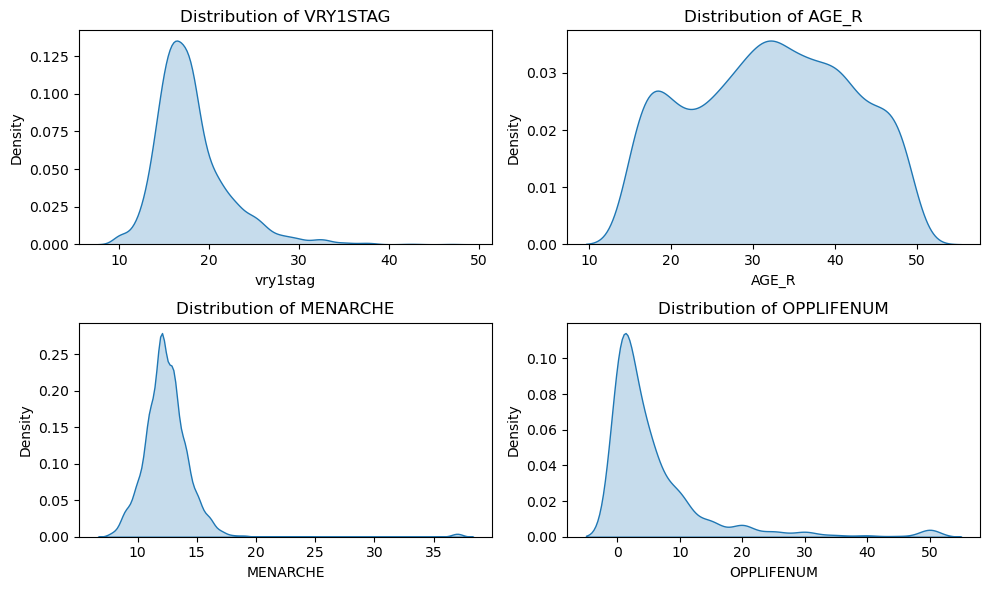

In [9]:
conti = ["vry1stag", 'AGE_R', 'MENARCHE', "OPPLIFENUM"]
df_data = df_train.copy()
#removed not ascertain questions
mask_out = (df_data['vry1stag'] != 97) & (df_data['MENARCHE'].isin([98,99]) == False) & (df_data['OPPLIFENUM'].isin([998,999]) == False)

df_data['OPPLIFENUM'] = df_data['OPPLIFENUM'].fillna(0)
df_data['MENARCHE'] = df_data['MENARCHE'].replace({96 : 37})
rows = int(np.ceil(len(conti)/2))
fig, ax= plt.subplots(ncols=2, nrows=rows, figsize=(10,rows*3))
ax = ax.flatten()

for i, col in enumerate(conti):
    sns.kdeplot(
        df_data[mask_out][col],
        fill=True,
        ax=ax[i]
    )
    ax[i].set_title(f"Distribution of {col.upper()}")

plt.tight_layout()

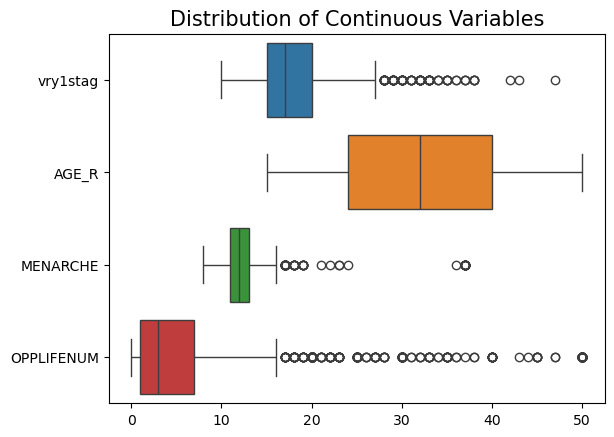

In [10]:
conti = ["vry1stag", 'AGE_R', 'MENARCHE', "OPPLIFENUM"]
         
sns.boxplot(
    df_data[mask_out][conti], 
    orient="h"
)

plt.title("Distribution of Continuous Variables", size=15);

Since there exists significant numbers of outliers, especially in the dependent variable, and they cannot be removed since they are genuine observations, overdispersion is very likely possibility. However, for the sake of the activity, we shall stick with Poisson Regression. But if overdispersion exists, we shall resort to Negative Binomial Regression instead for the final model.

## Categorical Variables

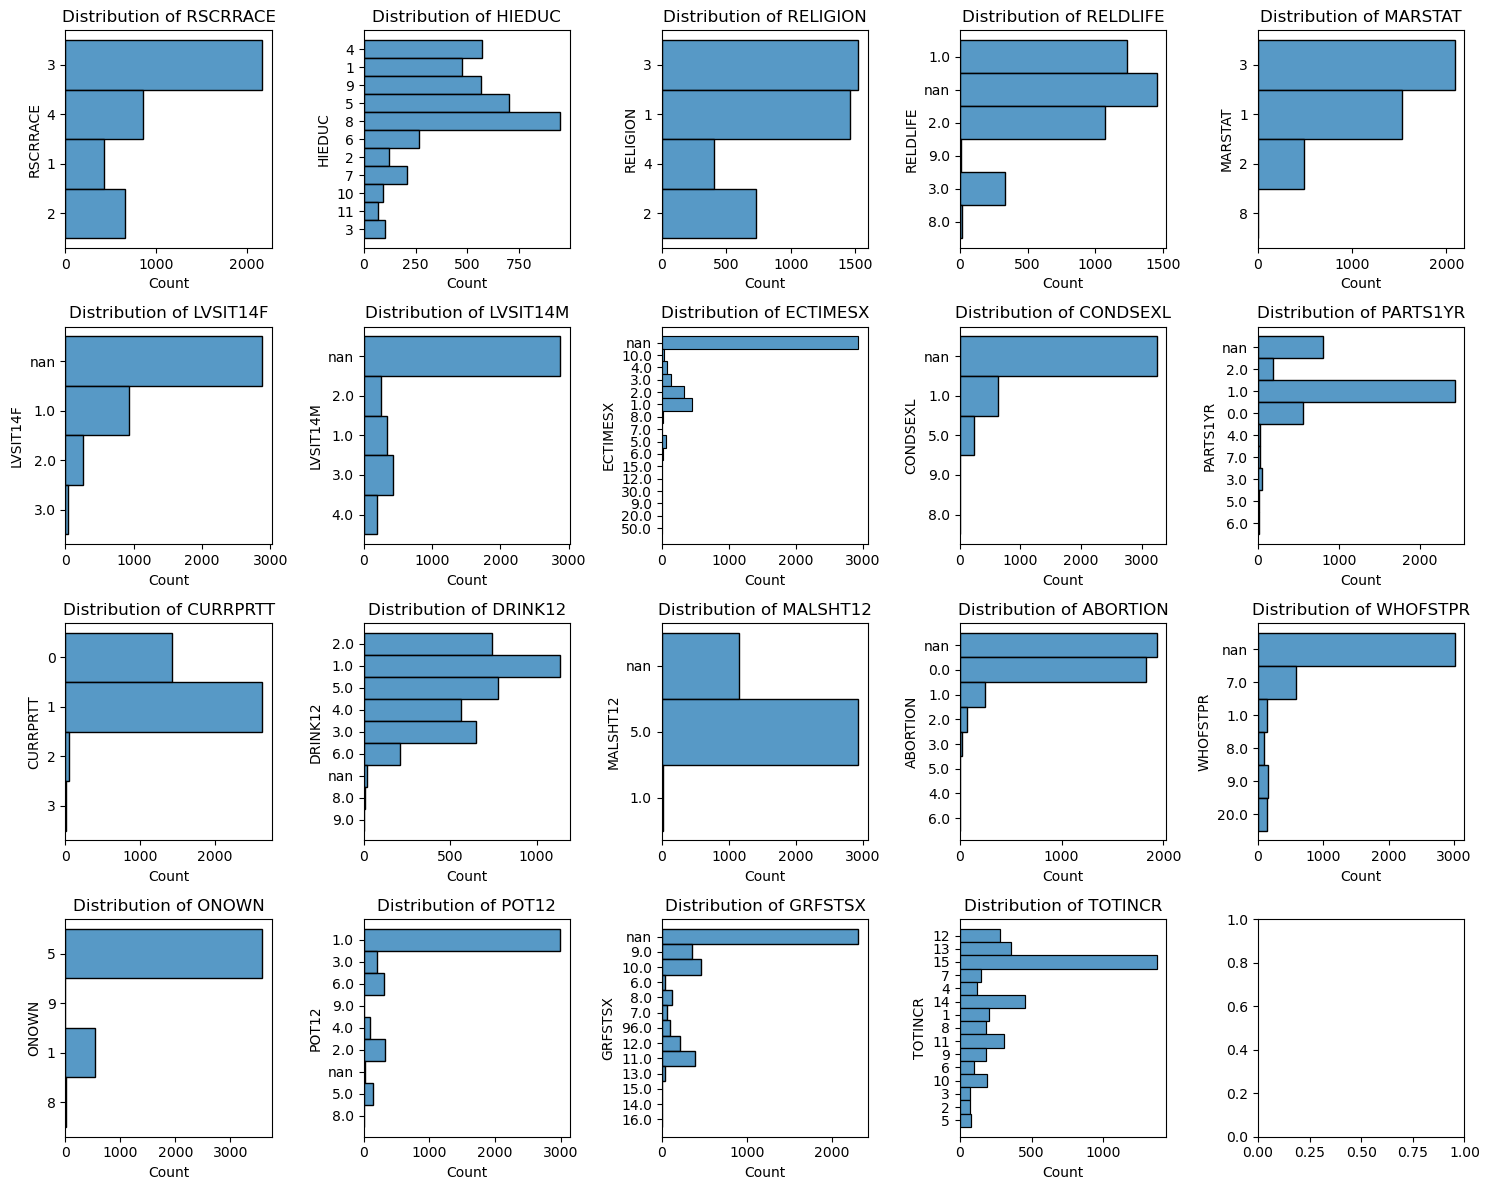

In [11]:
cols = df_train.drop(columns=conti).columns
rows = int(np.ceil(len(cols)/5))
fig, ax= plt.subplots(ncols=5, nrows=rows, figsize=(15,rows*3))
ax = ax.flatten()
mask_out = ((df_data['vry1stag'] != 97) & 
                (df_data['LVSIT14F'].isin([8,9]) == False) & 
                (df_data['LVSIT14M'].isin([8,9]) == False) &
                (df_data['ECTIMESX'].isin([98,99]) == False)&
                (df_data['CONDSEXL'].isin([98,99]) == False)&
                (df_data['MALSHT12'].isin([8,9]) == False) &
                (df_data['WHOFSTPR'].isin([98,99]) == False)&
                (df_data['GRFSTSX'].isin([98,99]) == False) &
                (df_data['MENARCHE'].isin([98,99]) == False) &
                (df_data['OPPLIFENUM'].isin([998,999]) == False)
                )
for i, col in enumerate(cols):
    sns.histplot(
        y=df_data[mask_out][col].astype(str),
        fill=True,
        ax=ax[i]
    )
    ax[i].set_title(f"Distribution of {col.upper()}")

plt.tight_layout()


### Missing Values

In [12]:
df_train.isna().sum()

AGE_R            0
RSCRRACE         0
HIEDUC           0
RELIGION         0
RELDLIFE      1559
MARSTAT          0
vry1stag       836
LVSIT14F      3098
LVSIT14M      3098
MENARCHE         0
ECTIMESX      3184
CONDSEXL      3546
PARTS1YR       836
CURRPRTT         0
DRINK12         19
MALSHT12      1243
ABORTION      2053
WHOFSTPR      3290
ONOWN            0
POT12           22
GRFSTSX       2459
TOTINCR          0
OPPLIFENUM     761
dtype: int64

Based on the *Codebook* file with consideration initial exploration, here are the implemented changes and masking done.

| Variable       | Wrangling Steps                                                                                                                                                              |
| :------------- | :--------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **OPPLIFENUM** | - `NaN` values filled with `0`. <br> - Rows where `OPPLIFENUM` is `998` or `999` are dropped.                                                                                    |
| **TOTINC**     | - Rows with `NaN` values in `TOTINC` are dropped.                                                                                                                              |
| **RELDLIFE**   | - Values replaced: `"8"` -> `4`, `"9"` -> `5`, `NaN` -> `6`.                                                                                                                   |
| **vry1stag**   | - Rows where `vry1stag` is `97` are dropped. <br> - Binned into categories: `'<=14 years'`, `'15-17 years'`, `'18-19 years'`, `'20+ years'`. `NaN`s become `"Never Had sex"`. <br> - This binned version is then One-Hot Encoded (original `vry1stag` column effectively replaced by dummies). |
| **LVSIT14F**   | - Rows where `LVSIT14F` is `8` or `9` are dropped. <br> - Values mapped using `map_f` (e.g., `1` -> `"Bio/adoptive mother"`, `None` -> `"both parents"`). <br> - Then One-Hot Encoded (original `LVSIT14F` column replaced by dummies). <br> - The specific dummy column `LVSIT14F_both parents` is dropped at the end. |
| **LVSIT14M**   | - Rows where `LVSIT14M` is `8` or `9` are dropped. <br> - Values mapped using `map_m` (e.g., `1` -> `"Bio/adoptive mother"`, `None` -> `"both parents"`). <br> - Then One-Hot Encoded (original `LVSIT14M` column replaced by dummies). |
| **ECTIMESX**   | - Rows where `ECTIMESX` is `98` or `99` are dropped. <br> - `NaN` values replaced with `"Never"`. <br> - Non-"Never" values are clustered using kmediod with Manhattan Distance; column updated with cluster labels. <br> - Then One-Hot Encoded (original `ECTIMESX` column replaced by dummies). |
| **CONDSEXL**   | - Rows where `CONDSEXL` is `98` or `99` are dropped. <br> - Values replaced: `NaN` -> `"inapplicable"`, `5` -> `0`. <br> - Then One-Hot Encoded (original `CONDSEXL` column replaced by dummies). |
| **MALSHT12**   | - Rows where `MALSHT12` is `8` or `9` are dropped. <br> - Transformed into multiple binary columns (`MALSHT12_0` to `MALSHT12_7`): `1` if `MALSHT12` equals the value (and not `NaN`), else `0`. <br> - Original `MALSHT12` column dropped. |
| **WHOFSTPR**   | - Rows where `WHOFSTPR` is `98` or `99` are dropped. <br> - Transformed into multiple binary columns (e.g., `WHOFSTPR_{val}` for each unique value): `1` if `WHOFSTPR` equals `val` (and not `NaN`), else `0`. <br> - Original `WHOFSTPR` column dropped. |
| **GRFSTSX**    | - Rows where `GRFSTSX` is `98` or `99` are dropped. <br> - `NaN` values filled with `"nosex_u18"`. <br> - Values mapped using `map_gr` (e.g., `14` -> `13`). <br> - Then One-Hot Encoded (original `GRFSTSX` column replaced by dummies). |
| **MENARCHE**   | - Rows where `MENARCHE` is `98` or `99` are dropped. <br> - Value `96` replaced with `37`. (Remains as a numerical column).                                                    |
| **PARTS1YR**   | - Value `5` replaced with `0`. <br> - Transformed into two binary columns: `PARTS1YR_no` (`1` if `PARTS1YR == 0` and not `NaN`), `PARTS1YR_yes` (`1` if `PARTS1YR == 1` and not `NaN`). <br> - Original `PARTS1YR` column dropped. |
| **ABORTION**   | - New column `Abortion_num` created, which is `ABORTION` with `NaN`s filled by `0`. <br> - Original `ABORTION` column dropped.                                                  |

### Clustering Code
Clustered using KMediod to consider the non Normal Distribution of the column `ECTIMESX`. Found the best k by calculation and *intertia* and *silhouette score* of each k. Standardize them then get the weighted average of the negative *intertia* (since lower is better) and *silhouette score* (since higher is better). The weight is 0.7 for *silhouette score* due to importance of distinctiveness between clusters over the compactness that the *inertia* calculates.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import kmedoids
import pickle

def cluster_this(X, col):
    n_clusters = range(2,13)
    inertia_errors = []
    silhouette_scores = []
    ss = StandardScaler()

    X_scaled = ss.fit_transform(X[[col]])
    # X_scaled_df = pd.DataFrame(X_scaled, columns=[col])
    

    for k in n_clusters:
        kmed = kmedoids.KMedoids(k, metric="manhattan", random_state=42)
        kmed.fit(X_scaled)
        inertia_errors.append(kmed.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmed.labels_))
    
    intertia = np.array(inertia_errors)
    mean_i = np.mean(intertia)
    std_i = np.std(intertia)
    stdz_i = (intertia - mean_i )/ std_i
    stdz_i = stdz_i*-1

    silhouette =   np.array(silhouette_scores)
    mean_s = np.mean(silhouette)
    std_s = np.std(silhouette)
    stdz_s = (silhouette - mean_s )/ std_s

    weight_inertia = 0.3
    weight_silhouette = 0.7

    combined_score = (weight_inertia * stdz_i) + (weight_silhouette * stdz_s)
    result = pd.Series(combined_score).sort_values(ascending=False)
    result.index = result.index + 2

    return result

def train_cluster(X, col, k):
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X[[col]].values)
    
    kmed = kmedoids.KMedoids(k, metric="manhattan", random_state=42)
    kmed.fit(X_scaled)
    
    with open(f"clustering_models/{col}_cluster.pkl", "wb") as f:
        pickle.dump((kmed, ss), f)
        print("Model saved to:", f"clustering_models/{col}_cluster.pkl")
    
    return kmed.labels_

def predict_cluster(X, col):
    with open(f"clustering_models/{col}_cluster.pkl", "rb") as f:
        loaded_model, scaler = pickle.load(f)
    
    X_scaled = scaler.transform(X[[col]].values)
    
    raw_prediction = loaded_model.predict(X_scaled)
    medoid_to_label = {idx: i for i, idx in enumerate(loaded_model.medoid_indices_)}
    labels = np.array([medoid_to_label.get(idx, -1) for idx in raw_prediction])
    
    return labels

In [14]:
samp = df_train['ECTIMESX'].dropna()
samp_frame = samp[samp < 80].to_frame()

cluster_this(samp_frame, 'ECTIMESX')

12    0.898516
11    0.850383
10    0.828359
9     0.693019
8     0.560741
7     0.465617
6     0.300801
5    -0.141694
4    -0.841484
3    -1.709144
2    -1.905113
dtype: float64

Choose 10 relatively effective but simpler clusters.

In [15]:
train_cluster(samp_frame, 'ECTIMESX', 10)

Model saved to: clustering_models/ECTIMESX_cluster.pkl


array([7, 3, 9, ..., 8, 4, 0], dtype=uint64)

In [16]:
labels = predict_cluster(samp_frame, "ECTIMESX")
pd_labels = pd.concat([samp_frame, pd.Series(labels, index=samp_frame.index).rename("cluster")], axis=1).groupby("cluster").agg(['median', 'max', 'min'])
sorted = pd_labels.loc[pd_labels['ECTIMESX']['median'].argsort()]
map_ect = {cluster : i for i,cluster in enumerate(sorted.index)}
sorted

ECTIMESX            
          median   max   min
cluster                     
9            1.0   1.0   1.0
8            2.0   2.0   2.0
4            3.0   3.0   3.0
3            4.0   4.0   4.0
0            5.0   5.0   5.0
5            6.0   6.0   6.0
2            8.0   9.0   7.0
7           10.0  12.0  10.0
6           15.0  20.0  15.0
1           30.0  50.0  30.0

### Wrangle Function

In [ ]:
map_f = {
    1: "Bio/adoptive mother",
    2: "Other mother figure",
    3: "No mother figure",
    None : "both parents"
}

map_m = {
    1: "Bio/adoptive mother",
    2: "Bio/adoptive father",
    3: "Step father",
    4: "Other father figure",
    None : "both parents"
}

map_gr = {
    14 : 13,
    15: 13,
    16 : 13,
    16 : 13
}

mappings = {
    "LVSIT14F" : map_f,
    "LVSIT14M" : map_m,
    "GRFSTSX" : map_gr
}


def wrangle(X, mappings, categories = {}):
    df_data = X.copy()

    to_one_hot = []
    to_cluster = []

    df_data['OPPLIFENUM'] = df_data['OPPLIFENUM'].fillna(0)
    to_drop_dependent = df_data['OPPLIFENUM'].isin([998,999])
    
    print("Invalid Dependent Rows (Refused and Don't Know):", to_drop_dependent.sum())

    df_data = df_data[~to_drop_dependent]
    
    current_n = len(df_data)
    
    df_data['RELDLIFE'] = df_data['RELDLIFE'].replace({
            8 : 4,
            9 : 5,
            np.nan : 6
        })
    
    # drop shits
    mask_out = ((df_data['vry1stag'] != 97) & 
                (df_data['LVSIT14F'].isin([8,9]) == False) & 
                (df_data['LVSIT14M'].isin([8,9]) == False) &
                (df_data['ECTIMESX'].isin([98,99]) == False)&
                (df_data['CONDSEXL'].isin([98,99]) == False)&
                (df_data['MALSHT12'].isin([8,9]) == False) &
                (df_data['WHOFSTPR'].isin([98,99]) == False)&
                (df_data['GRFSTSX'].isin([98,99]) == False) &
                (df_data['MENARCHE'].isin([98,99]) == False) &
                (df_data['MARSTAT'].isin([8,9]) == False) &
                (df_data['DRINK12'].isin([9]) == False) &
                (df_data['POT12'].isin([9]) == False) &
                (df_data['ONOWN'].isin([8,9]) == False)
                )
    df_data = df_data[mask_out]

    #MENARCHE handling
    df_data['MENARCHE'] = df_data['MENARCHE'].replace({96 : 37})
    
    #ECTIMESX handling
    ect = df_data['ECTIMESX'].replace({np.nan : "Never"})
    mask_ect = (ect != "Never")
    ect = ect[mask_ect].astype(float).to_frame()
    to_cluster.append(["ECTIMESX", mask_ect])
    
    #CONDSEXL handling
    df_data['CONDSEXL'] =   df_data['CONDSEXL'].replace({np.NaN : "inapplicable", 5:0})
    to_one_hot.append(df_data['CONDSEXL'])
    
    #PARTS1YR handling
    had_sex = df_data['PARTS1YR'].isna() == False
    df_data['PARTS1YR'] = df_data['PARTS1YR'].replace({5:0})
    map_par = ["no", "yes"]
    for i in range(2):
        df_data[f'PARTS1YR_{map_par[i]}'] = ((df_data['PARTS1YR'] == i) & had_sex).astype(int)
    df_data.drop(columns="PARTS1YR", inplace=True)
    
    #MALSHT12 handling
    had_sex = df_data['MALSHT12'].isna() == False
    for i in df_data['MALSHT12'].dropna().unique():
        df_data[f'MALSHT12_{i}'] = ((df_data['MALSHT12'] == i) & had_sex).astype(int)
    df_data.drop(columns="MALSHT12", inplace=True)

    #ABORTION handling
    df_data['Abortion_num'] = df_data['ABORTION'].fillna(0)
    df_data.drop(columns="ABORTION", inplace=True)

    #WHOFSTPR handling
    applicable = df_data['WHOFSTPR'].isna() == False
    unique_val = df_data['WHOFSTPR'].dropna().unique()
    for val in unique_val:
        df_data[f"WHOFSTPR_{val}"] =  ((df_data['WHOFSTPR'] == val) & applicable).astype(int)
    df_data.drop(columns="WHOFSTPR", inplace=True)


    #GRFSTSX handling
    df_data['GRFSTSX'] = df_data['GRFSTSX'].fillna("nosex_u18")

    #DRINK12 handling
    to_one_hot.append(df_data['DRINK12'])    

    #POT12 handling
    to_one_hot.append(df_data['POT12'])

    #Clustering loop
    for col, mask in to_cluster:
        data_to_predict = df_data[mask][[col]]
        labels = predict_cluster(data_to_predict, col)
        df_data.loc[data_to_predict.index, col] = labels
        to_one_hot.append(df_data[col])


    first_sex = pd.cut(df_data['vry1stag'], 
        bins=[0, 14, 17, 19, 49],
        labels=['<=14 years', '15-17 years', '18-19 years', '20+ years']
            ).astype(str)
    first_sex[first_sex == "nan"] = "Never Had sex"
    to_one_hot.append(first_sex)

    #mapping loop
    for key, map in mappings.items():
        df_data[key] = df_data[key].map(map)
        to_one_hot.append(df_data[key])

    #one hot loop
    combine = []
    for col in to_one_hot:
        if col.name not in categories.keys():
            categories[col.name] = col.astype("category").cat.categories
        temp_cat = pd.Categorical(col, categories=categories[col.name])
        dum_temp = pd.get_dummies(temp_cat, dtype=int, drop_first=True, prefix=col.name)
        dum_temp.index = col.index
        combine.append(dum_temp)
        df_data.drop(columns=col.name, inplace=True)

    combine.append(df_data)
    
    df_final = pd.concat(combine, axis=1)
    
    latest_n = len(df_final)
    print(f"Total Rows Dropped: {(current_n - latest_n)*100/current_n}%")

    df_final.drop(columns="LVSIT14F_both parents", inplace=True)

    cols = df_final.columns
    cols_processed =[f'{col.replace(".0", "").replace("+", "more").replace(" ", "_").replace("<=", "leq").replace("/", "or").replace("-", "_")}' for col in cols]
    df_final.columns = cols_processed

    return df_final, categories
df_clean, cats_map = wrangle(df_train, mappings=mappings)

Invalid Dependent Rows (Refused and Don't Know): 253
Total Rows Dropped: 2.8469750889679717%


In [18]:
df_clean.agg(["unique"]).T

,unique
CONDSEXL_1,"[0, 1]"
CONDSEXL_8,"[0, 1]"
CONDSEXL_9,"[0, 1]"
CONDSEXL_inapplicable,"[1, 0]"
DRINK12_2,"[1, 0]"
DRINK12_3,"[0, 1]"
DRINK12_4,"[0, 1]"
DRINK12_5,"[0, 1]"
DRINK12_6,"[0, 1]"
DRINK12_8,"[0, 1]"


### Correlation

Text(0.5, 1.0, 'Correlation Heatmap of the Processed Dataset')

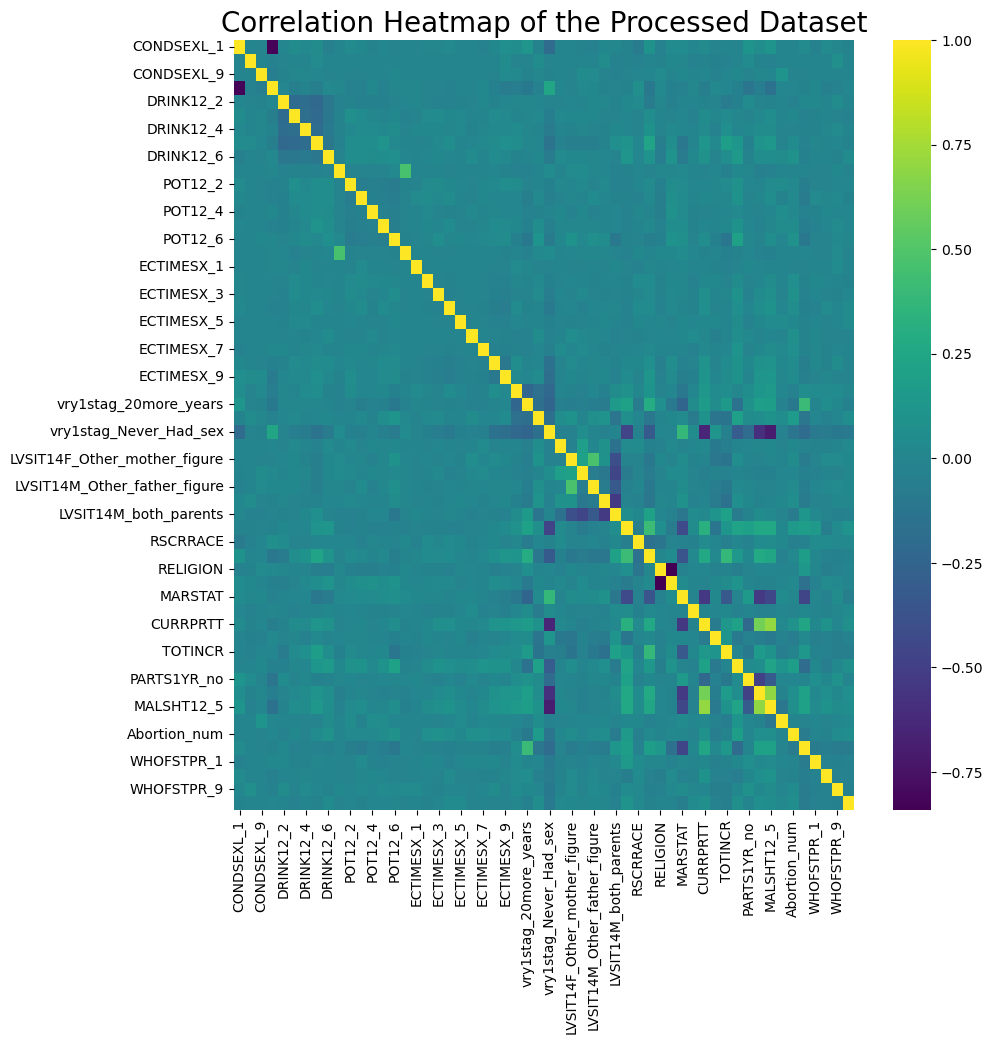

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(
    df_clean.corr(),
    cmap="viridis"
)
plt.title("Correlation Heatmap of the Processed Dataset", size=20)

In [20]:
corr = df_clean.corr().stack().rename("PearsonCorrelation").reset_index()
mask = (corr['level_0'] != corr['level_1']) & (corr['PearsonCorrelation'] >= 0.70)
corr[mask]

,level_0,level_1,PearsonCorrelation
2400,CURRPRTT,MALSHT12_5,0.702254
2730,MALSHT12_5,CURRPRTT,0.702254


We can still make do with .70 correlation.


## Modelling
Let us start with Poisson Regression with regularization for feature selection. To find the best hyperparametes, GridSearch will be done with kfold=5.

In [22]:
def cal_overdispesion(df_data, params, formula):
    re_model = smf.glm(formula=formula, data=df_data, family=sm.families.Poisson())
    regularized_results = re_model.fit_regularized(
                method='elastic_net',
                alpha=params['alpha'],         
                L1_wt=params['L1_wt'],
                maxiter=10000
            )
    params_valid = regularized_results.params[regularized_results.params != 0]
    params_valid.sort_values(ascending=False)

    formula = 'OPPLIFENUM ~ ' + " + ".join(params_valid.drop("Intercept", errors="ignore").index)
    unr_model = smf.glm(formula=formula, data=df_data, family=sm.families.Poisson())
    unregularized_results_pois = unr_model.fit()
    overdispersion = unregularized_results_pois.deviance / unregularized_results_pois.df_resid
    return overdispersion


In [23]:
formula = 'OPPLIFENUM ~ ' + " + ".join(df_clean.drop(columns=["OPPLIFENUM"]))

alphas = [0.01, 0.1, 0.5, 1.0, 10.0]
l1_wts = [0.1, 0.5, 0.9, 1.0]

best_score = float('inf')
best_params = {}
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for alpha, l1_wt in product(alphas, l1_wts):
    cv_scores = []
    
    for train_idx, val_idx in kf.split(df_clean):
        train_data = df_clean.iloc[train_idx]
        val_data = df_clean.iloc[val_idx]
        
        re_model = smf.glm(formula=formula, data=train_data, family=sm.families.Poisson())
        
        try:
            model_fit = re_model.fit_regularized(
                method='elastic_net',
                alpha=alpha,
                L1_wt=l1_wt,
                maxiter=2000
            )
            
            predictions = model_fit.predict(val_data)
            score = mean_squared_error(val_data['OPPLIFENUM'], predictions)
            cv_scores.append(score)
        except:
            cv_scores.append(float('inf'))
    
    avg_score = np.mean(cv_scores)
    overdis = cal_overdispesion(df_clean, {'alpha': alpha,'L1_wt': l1_wt}, formula)
    results.append({
        'alpha': alpha,
        'L1_wt': l1_wt,
        'avg_mse': avg_score,
        'overdis_params' : overdis
    })
    
    if avg_score < best_score:
        best_score = avg_score
        best_params = {
            'alpha': alpha,
            'L1_wt': l1_wt
        }


results_df = pd.DataFrame(results)
print("Best parameters:", best_params)
print("Best MSE:", best_score)

Best parameters: {'alpha': 0.01, 'L1_wt': 0.1}
Best MSE: 54.22650839069981


In [26]:
results_df.sort_values("avg_mse").head(20)

,alpha,L1_wt,avg_mse,overdis_params
0,0.01,0.1,54.226508,4.290659
1,0.01,0.5,54.334660,4.296870
3,0.01,1.0,54.370134,4.296870
2,0.01,0.9,54.463904,4.320549
4,0.10,0.1,55.721707,4.333666
5,0.10,0.5,57.206010,4.372102
6,0.10,0.9,58.202503,4.697114
7,0.10,1.0,58.267722,4.737102
8,0.50,0.1,59.902721,4.419589
12,1.00,0.1,63.493816,4.806298


In [79]:
results_df.sort_values("avg_mse").head(10)

,alpha,L1_wt,avg_mse,overdis_params
0,0.01,0.1,54.226508,4.290659
1,0.01,0.5,54.334660,4.296870
3,0.01,1.0,54.370134,4.296870
2,0.01,0.9,54.463904,4.320549
4,0.10,0.1,55.721707,4.333666
5,0.10,0.5,57.206010,4.372102
6,0.10,0.9,58.202503,4.697114
7,0.10,1.0,58.267722,4.737102
8,0.50,0.1,59.902721,4.419589
12,1.00,0.1,63.493816,4.806298


In [95]:
results_df.to_csv("results_pois.csv")

Technically, the best parameters are {'alpha': 0.01, 'L1_wt': 0.1}. But let us choose {'alpha': 0.01, 'L1_wt': 1} for relatively (but lower) simillar score yet simpler model. For interpretability purposes, it is within our interest to choose a regularization parameter that's stricter (without sacrificing much predictive power) to come up with simpler model. Choosing an 'L1_wt' will make that happen.

In [45]:
best_params_poisson ={'alpha': 0.10, 'L1_wt': 0.1}

In [46]:
response = "OPPLIFENUM"

formula = f'{response} ~ ' + " + ".join(df_clean.drop(columns=[response]))
re_model = smf.glm(formula=formula, data=df_clean, family=sm.families.Poisson())
regularized_results = re_model.fit_regularized(
            method='elastic_net',
            alpha=best_params_poisson['alpha'],         
            L1_wt=best_params_poisson['L1_wt'],
            maxiter=10000
        )
regularized_results

In [47]:
params_valid = regularized_results.params[regularized_results.params != 0]
params_valid.sort_values(ascending=False)

MALSHT12_5                      0.578348
POT12_6                         0.470499
MALSHT12_1                      0.434939
ECTIMESX_7                      0.332635
POT12_2                         0.261999
DRINK12_6                       0.257441
POT12_5                         0.233583
vry1stag_leq14_years            0.217961
POT12_3                         0.214079
ECTIMESX_3                      0.207588
ECTIMESX_4                      0.150444
ECTIMESX_8                      0.143683
DRINK12_5                       0.132220
ECTIMESX_9                      0.123269
LVSIT14M_Step_father            0.121560
POT12_4                         0.111101
MARSTAT                         0.097991
ECTIMESX_5                      0.095762
CURRPRTT                        0.094252
ECTIMESX_6                      0.071414
HIEDUC                          0.069775
Abortion_num                    0.056546
LVSIT14F_Other_mother_figure    0.053699
WHOFSTPR_20                     0.052699
ECTIMESX_2      

In [48]:
formula = 'OPPLIFENUM ~ ' + " + ".join(params_valid.drop("Intercept", errors="ignore").index)
unr_model = smf.glm(formula=formula, data=df_clean, family=sm.families.Poisson())
unregularized_results_pois = unr_model.fit()
unregularized_results_pois.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Generalized linear model
=============================================================================
Model:                   GLM                  AIC:                28775.2918 
Link Function:           Log                  BIC:                -16142.5843
Dependent Variable:      OPPLIFENUM           Log-Likelihood:     -14345.    
Date:                    2025-05-18 10:28     LL-Null:            -23998.    
No. Observations:        4095                 Deviance:           17560.     
Df Model:                42                   Pearson chi2:       3.51e+04   
Df Residuals:            4052                 Scale:              1.0000     
Method:                  IRLS                                                
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                     0.5767   0.0822   7.0190 0.0000  0.4157  0.7377
CONDSEXL_inapplicable         0.0586   0.0155   3.7722 0.0002  0.0282  0.0891
DRINK12_5                     0.1230   0.0158   7.7843 0.0000  0.0920  0.1539
DRINK12_6                     0.2499   0.0228  10.9772 0.0000  0.2053  0.2945
DRINK12_8                     0.9289   0.1110   8.3651 0.0000  0.7112  1.1465
POT12_2                       0.3024   0.0215  14.0614 0.0000  0.2602  0.3445
POT12_3                       0.2853   0.0249  11.4589 0.0000  0.2365  0.3341
POT12_4                       0.2031   0.0386   5.2650 0.0000  0.1275  0.2787
POT12_5                       0.3174   0.0291  10.9106 0.0000  0.2604  0.3744
POT12_6                       0.5055   0.0195  25.9773 0.0000  0.4673  0.5436
ECTIMESX_2                    0.2181   0.0577   3.7790 0.0002  0.1050  0.3312
ECTIMESX_3                    0.3515   0.0357   9.8534 0.0000  0.2816  0.4215
ECTIMESX_4                    0.2263   0.0299   7.5727 0.0000  0.1677  0.2849
ECTIMESX_5                    0.4221   0.0643   6.5610 0.0000  0.2960  0.5482
ECTIMESX_6                    0.6808   0.0842   8.0822 0.0000  0.5157  0.8458
ECTIMESX_7                    0.5755   0.0407  14.1260 0.0000  0.4956  0.6553
ECTIMESX_8                    0.1567   0.0208   7.5172 0.0000  0.1159  0.1976
ECTIMESX_9                    0.1433   0.0187   7.6521 0.0000  0.1066  0.1801
vry1stag_18_19_years         -0.2111   0.0181 -11.6699 0.0000 -0.2466 -0.1756
vry1stag_20more_years        -0.5699   0.0221 -25.7522 0.0000 -0.6133 -0.5265
vry1stag_leq14_years          0.1517   0.0177   8.5871 0.0000  0.1171  0.1863
vry1stag_Never_Had_sex       -2.3059   0.0574 -40.1698 0.0000 -2.4184 -2.1934
LVSIT14F_No_mother_figure    -0.4013   0.0651  -6.1613 0.0000 -0.5290 -0.2737
LVSIT14F_Other_mother_figure  0.0428   0.0243   1.7632 0.0779 -0.0048  0.0903
LVSIT14M_Step_father          0.1354   0.0192   7.0529 0.0000  0.0978  0.1731
AGE_R                         0.0259   0.0009  29.2952 0.0000  0.0241  0.0276
RSCRRACE                      0.0125   0.0083   1.5029 0.1329 -0.0038  0.0287
HIEDUC                        0.0612   0.0033  18.4566 0.0000  0.0547  0.0677
RELIGION                     -0.0354   0.0063  -5.6319 0.0000 -0.0477 -0.0231
MARSTAT                       0.0193   0.0094   2.0390 0.0414  0.0007  0.0378
MENARCHE                     -0.0073   0.0035  -2.0574 0.0396 -0.0142 -0.0003
CURRPRTT                     -0.0189   0.0161  -1.1723 0.2411 -0.0504  0.0127
ONOWN                        -0.0163   0.0044  -3.6905 0.0002 -0.0250 -0.0076
TOTINCR                      -0.0019   0.0019  -1.0099 0.3125 -0.0056  0.0018
PARTS1YR_yes                 -0.4844   0.0166 -29.1902 0.0000 -0.5169 -0.4519
MALSHT12_5                    0.6676   0.0257  25.9278 0.0000  0.6171  0.7180
MALSHT12_1                    1.1501   0.0560  20.5311 0.0000  1.0403  1.2599
Abortion_num                  0.0277   0.0102   2.7175 0.0066  0.0077  0.

In [49]:
overdispersion = unregularized_results_pois.deviance / unregularized_results_pois.df_resid

if overdispersion > 1.3:
    print(f"Overdispersion occurs\nvalue = {overdispersion}")
else:
    print(f"Overdispersion did not occur\nvalue = {overdispersion}")

Overdispersion occurs
value = 4.333666054237197


Since overdispersion exists, as was expected earlier, let us conduct a Negative Binomial Regression instead and grid search for best alpha value. For the sake of time efficiency, the tuning of both the alpha and L1_wt in regularized fitting will be ommited and will instead use the previously acquired parameters from the Poisson Regression.

For reference, the training time including the regularized fitting parameters will tally up to 18 hours.

In [27]:
def cal_overdispesion_bin(df_data, params, formula):
    re_model = smf.glm(formula=formula, data=df_data, family=sm.families.NegativeBinomial(alpha=params['alpha_binom']))
    regularized_results = re_model.fit_regularized(
                method='elastic_net',
                alpha=params['alpha'],         
                L1_wt=params['L1_wt'],
                maxiter=10000
            )
    params_valid = regularized_results.params[regularized_results.params != 0]
    params_valid.sort_values(ascending=False)

    formula = 'OPPLIFENUM ~ ' + " + ".join(params_valid.drop("Intercept", errors="ignore").index)
    unr_model = smf.glm(formula=formula, data=df_data, family=sm.families.NegativeBinomial(alpha=params['alpha_binom']))
    unregularized_results_pois = unr_model.fit()
    overdispersion = unregularized_results_pois.deviance / unregularized_results_pois.df_resid
    return overdispersion

In [34]:
from tqdm import tqdm

formula = 'OPPLIFENUM ~ ' + " + ".join(df_clean.drop(columns=["OPPLIFENUM"]))

alphas_binom_to_tune = [0.1, 0.5, 1.0, 2.0] 
reg_alphas_to_tune = [0.01, 0.1, 0.5, 1.0]
l1_weights_to_tune = [0.1, 0.5, 0.9, 1.0]

best_score = float('inf')
best_params_binom = {}
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for alpha_binom, alpha_reg, l1_w in tqdm(product(alphas_binom_to_tune, reg_alphas_to_tune, l1_weights_to_tune)):
    cv_scores = []
    
    for train_idx, val_idx in kf.split(df_clean):
        train_data = df_clean.iloc[train_idx]
        val_data = df_clean.iloc[val_idx]
        
        re_model = smf.glm(formula=formula, data=train_data, family=sm.families.NegativeBinomial(alpha=alpha_binom))
        
        try:
            model_fit = re_model.fit_regularized(
                method='elastic_net',
                alpha=alpha_reg,
                L1_wt=l1_w,
                maxiter=2000
            )
            
            predictions = model_fit.predict(val_data)
            score = mean_squared_error(val_data['OPPLIFENUM'], predictions)
            cv_scores.append(score)
        except:
            cv_scores.append(float('inf'))
    
    avg_score = np.mean(cv_scores)
    overdis = cal_overdispesion_bin(df_clean, {'alpha': alpha_reg,'L1_wt': l1_w, 'alpha_binom' : alpha_binom}, formula)
    results.append({
        'alpha': alpha_reg,
        'L1_wt': l1_w,
        'alpha_binom': alpha_binom,
        'avg_mse': avg_score,
        'overdisp' : overdis
    })
    
    if avg_score < best_score:
        best_score = avg_score
        best_params_binom = {
            'alpha': alpha_reg,
            'L1_wt': l1_w,
            'alpha_binom': alpha_binom,
        }

results_binom_df = pd.DataFrame(results)
print("Best parameters:", best_params_binom)
print("Best MSE:", best_score)

64it [1:41:50, 95.48s/it] 

Best parameters: {'alpha': 0.01, 'L1_wt': 1.0, 'alpha_binom': 0.1}
Best MSE: 55.02295875212339


In [38]:
results_binom_df.sort_values("avg_mse").head(20)

,alpha,L1_wt,alpha_binom,avg_mse,overdisp
3,0.01,1.0,0.1,55.022959,2.265840
1,0.01,0.5,0.1,55.259540,2.238389
2,0.01,0.9,0.1,55.375307,2.262001
0,0.01,0.1,0.1,55.647682,2.239168
17,0.01,0.5,0.5,57.160240,0.966760
16,0.01,0.1,0.5,57.248578,0.952015
18,0.01,0.9,0.5,57.279296,0.971139
4,0.10,0.1,0.1,57.411768,2.279693
19,0.01,1.0,0.5,57.706256,0.975821
33,0.01,0.5,1.0,57.920992,0.612056


In [80]:
results_binom_df.sort_values("avg_mse").head(10)

,alpha,L1_wt,alpha_binom,avg_mse,overdisp
3,0.01,1.0,0.1,55.022959,2.265840
1,0.01,0.5,0.1,55.259540,2.238389
2,0.01,0.9,0.1,55.375307,2.262001
0,0.01,0.1,0.1,55.647682,2.239168
17,0.01,0.5,0.5,57.160240,0.966760
16,0.01,0.1,0.5,57.248578,0.952015
18,0.01,0.9,0.5,57.279296,0.971139
4,0.10,0.1,0.1,57.411768,2.279693
19,0.01,1.0,0.5,57.706256,0.975821
33,0.01,0.5,1.0,57.920992,0.612056


In [94]:
results_binom_df.to_csv("results_binom.csv")

In [39]:
best_params_binom = {'alpha': 0.01, 'L1_wt': 0.5, 'alpha_binom': 0.5}

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import KFold
from itertools import product

In [40]:
formula = 'OPPLIFENUM ~ ' + " + ".join(df_clean.drop(columns=["OPPLIFENUM"]))

final_model = smf.glm(
    formula=formula, 
    data=df_clean, 
    family=sm.families.NegativeBinomial(alpha=best_params_binom['alpha_binom'])
)

final_results_binom = final_model.fit_regularized(
    method='elastic_net',
    alpha=best_params_binom['alpha'],
    L1_wt=best_params_binom['L1_wt'],
    maxiter=2000,
    cnvrg_tol=1e-6
)

selected_params = final_results_binom.params[final_results_binom.params != 0]
print(f"Selected parameters: \n{selected_params}")

Selected parameters: 
Intercept                 0.110484
CONDSEXL_1               -0.041523
DRINK12_3                 0.004997
DRINK12_5                 0.125094
DRINK12_6                 0.220591
POT12_2                   0.273100
POT12_3                   0.191434
POT12_4                   0.466031
POT12_5                   0.258532
POT12_6                   0.532914
ECTIMESX_3                0.188721
ECTIMESX_4                0.152729
ECTIMESX_7                0.242102
ECTIMESX_8                0.147612
ECTIMESX_9                0.113697
vry1stag_18_19_years     -0.175723
vry1stag_20more_years    -0.550081
vry1stag_leq14_years      0.249300
vry1stag_Never_Had_sex   -1.968690
LVSIT14M_Step_father      0.093809
AGE_R                     0.030518
HIEDUC                    0.067526
RELIGION                 -0.018899
ONOWN                    -0.003159
PARTS1YR_yes             -0.538570
MALSHT12_5                0.861751
MALSHT12_1                0.634534
Abortion_num              0.09445

In [81]:
formula = 'OPPLIFENUM ~ ' + " + ".join(selected_params.drop("Intercept", errors="ignore").index)
unr_model = smf.glm(formula=formula, data=df_clean, family=sm.families.NegativeBinomial(alpha=best_params_binom['alpha_binom']))
unregularized_results_binom = unr_model.fit()
unregularized_results_binom.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
=======================================================================
Model:                 GLM                AIC:              19423.2079 
Link Function:         Log                BIC:              -29858.7939
Dependent Variable:    OPPLIFENUM         Log-Likelihood:   -9678.6    
Date:                  2025-05-18 11:07   LL-Null:          -12650.    
No. Observations:      4095               Deviance:         3927.0     
Df Model:              32                 Pearson chi2:     1.17e+04   
Df Residuals:          4062               Scale:            1.0000     
Method:                IRLS                                            
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.3088   0.1050   2.9413 0.0033  0.1030  0.5145
CONDSEXL_1             -0.0906   0.0390  -2.3247 0.0201 -0.1670 -0.0142
DRINK12_3               0.0128   0.0406   0.3144 0.7532 -0.0668  0.0923
DRINK12_5               0.1252   0.0380   3.2961 0.0010  0.0508  0.1997
DRINK12_6               0.2387   0.0607   3.9304 0.0001  0.1197  0.3578
POT12_2                 0.3163   0.0516   6.1345 0.0000  0.2153  0.4174
POT12_3                 0.2650   0.0612   4.3309 0.0000  0.1451  0.3849
POT12_4                 0.7481   0.0852   8.7859 0.0000  0.5813  0.9150
POT12_5                 0.3603   0.0735   4.9016 0.0000  0.2162  0.5044
POT12_6                 0.5793   0.0502  11.5381 0.0000  0.4809  0.6777
ECTIMESX_3              0.3498   0.0948   3.6889 0.0002  0.1639  0.5356
ECTIMESX_4              0.2502   0.0716   3.4962 0.0005  0.1100  0.3905
ECTIMESX_7              0.4998   0.1213   4.1198 0.0000  0.2620  0.7375
ECTIMESX_8              0.1823   0.0483   3.7769 0.0002  0.0877  0.2769
ECTIMESX_9              0.1434   0.0430   3.3309 0.0009  0.0590  0.2277
vry1stag_18_19_years   -0.2310   0.0399  -5.7859 0.0000 -0.3093 -0.1528
vry1stag_20more_years  -0.5654   0.0435 -13.0124 0.0000 -0.6506 -0.4802
vry1stag_leq14_years    0.2059   0.0442   4.6600 0.0000  0.1193  0.2925
vry1stag_Never_Had_sex -2.2914   0.0791 -28.9551 0.0000 -2.4465 -2.1363
LVSIT14M_Step_father    0.1142   0.0451   2.5326 0.0113  0.0258  0.2027
AGE_R                   0.0281   0.0019  15.0298 0.0000  0.0245  0.0318
HIEDUC                  0.0652   0.0067   9.7670 0.0000  0.0521  0.0783
RELIGION               -0.0282   0.0140  -2.0108 0.0443 -0.0557 -0.0007
ONOWN                  -0.0122   0.0102  -1.1943 0.2323 -0.0323  0.0078
PARTS1YR_yes           -0.6433   0.0377 -17.0618 0.0000 -0.7172 -0.5694
MALSHT12_5              0.9277   0.0512  18.1261 0.0000  0.8274  1.0280
MALSHT12_1              1.3465   0.1765   7.6283 0.0000  1.0005  1.6924
Abortion_num            0.0787   0.0268   2.9328 0.0034  0.0261  0.1313
WHOFSTPR_7             -1.3432   0.0530 -25.3215 0.0000 -1.4472 -1.2392
WHOFSTPR_1             -0.2699   0.0736  -3.6653 0.0002 -0.4142 -0.1256
WHOFSTPR_8             -1.1815   0.1089 -10.8470 0.0000 -1.3949 -0.9680
WHOFSTPR_9             -0.1890   0.0697  -2.7128 0.0067 -0.3255 -0.0524
WHOFSTPR_20             0.0795   0.0705   1.1270 0.2598 -0.0588  0.2178
=======================================================================

"""

In [43]:
overdispersion = unregularized_results_binom.deviance / unregularized_results_binom.df_resid

if overdispersion > 1.3:
    print(f"Overdispersion occurs\nvalue = {overdispersion}")
else:
    print(f"Overdispersion did not occur\nvalue = {overdispersion}")

Overdispersion did not occur
value = 0.9667603300612909


---
## Evaluation

In [50]:
df_test_clean = wrangle(df_test, mappings, categories=cats_map)[0]

results = []
y_actual = df_test_clean['OPPLIFENUM']
y_train = df_clean['OPPLIFENUM']

# baseline
score = mean_squared_error(y_actual, [y_actual.mean()]*len(y_actual))
score_1 = mean_squared_error(y_train, [y_actual.mean()]*len(y_train))

results.append({
    "model" : "Baseline",
    "params" : 0,
    "test_mse" : score,
    "train_mse" : score_1
})
# Unr Binom
y_pred = unregularized_results_binom.predict(df_test_clean)
score = mean_squared_error(y_actual, y_pred)
score_1 = mean_squared_error(y_train, unregularized_results_binom.predict(df_clean))

results.append({
    "model" : "Binom_unr",
    "params" : len(unregularized_results_binom.params),
    "test_mse" : score,
    "train_mse" : score_1
})
# Reg Binom
y_pred = final_results_binom.predict(df_test_clean)
score = mean_squared_error(y_actual, y_pred)
score_1 = mean_squared_error(y_train, final_results_binom.predict(df_clean))

results.append({
    "model" : "Binom_reg",
    "params" : len(final_results_binom.params),
    "test_mse" : score,
    "train_mse" : score_1
})
# Unr Pois
y_pred = unregularized_results_pois.predict(df_test_clean)
score = mean_squared_error(y_actual, y_pred)
score_1 = mean_squared_error(y_train, unregularized_results_pois.predict(df_clean))

results.append({
    "model" : "Pois_unr",
    "params" : len(unregularized_results_pois.params),
    "test_mse" : score,
    "train_mse" : score_1
})
# Reg Pois
y_pred = regularized_results.predict(df_test_clean)
score = mean_squared_error(y_actual, y_pred)
score_1 = mean_squared_error(y_train, regularized_results.predict(df_clean))

results.append({
    "model" : "Pois_reg",
    "params" : len(regularized_results.params),
    "test_mse" : score,
    "train_mse" : score_1
})

pd.DataFrame(results)

Invalid Dependent Rows (Refused and Don't Know): 54
Total Rows Dropped: 2.537593984962406%


,model,params,test_mse,train_mse
0,Baseline,0,80.356538,79.021221
1,Binom_unr,33,56.258788,56.628048
2,Binom_reg,56,55.362855,55.132599
3,Pois_unr,43,54.054384,51.617108
4,Pois_reg,56,54.461459,53.612255


$100 * e^{\beta_{k} - 1} \ \ \forall k \in params_{reg}$ where $\beta_k$ is the coeficient of parameter k

In [ ]:
(np.exp(df_results['Coefficient']) - 1)

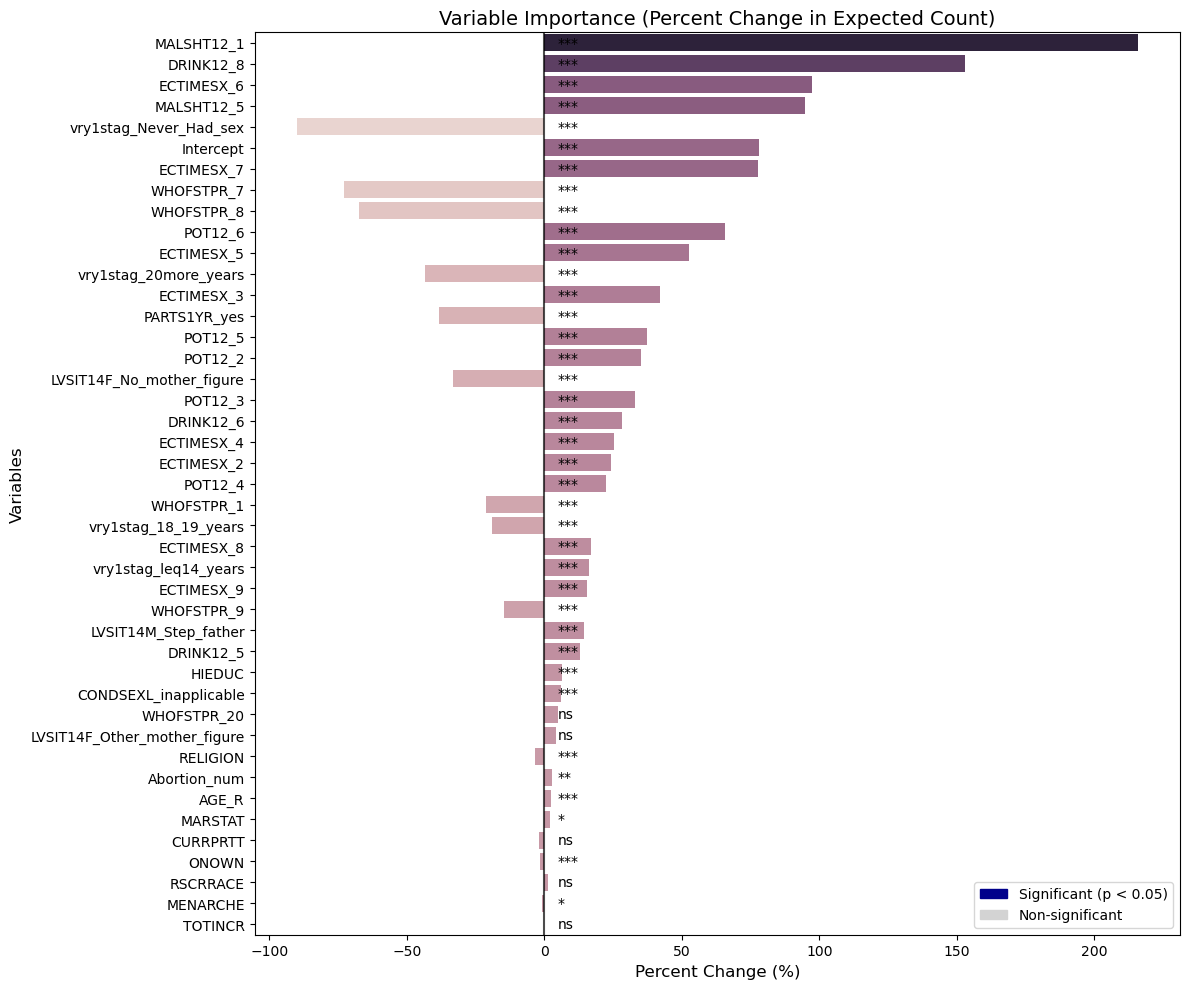

In [93]:
df_results = pd.DataFrame({
    'Variable': unregularized_results_pois.model.exog_names,
    'Coefficient': unregularized_results_pois.params,
    'StdErr': unregularized_results_pois.bse,
    'z-value': unregularized_results_pois.tvalues,
    'p-value': unregularized_results_pois.pvalues,
    'CI_lower': unregularized_results_pois.conf_int()[0],
    'CI_upper': unregularized_results_pois.conf_int()[1]
})

df_results['Percent_Change'] = 100 * (np.exp(df_results['Coefficient']) - 1)
df_results['Abs_Percent_Change'] = abs(df_results['Percent_Change'])

df_results = df_results.sort_values('Abs_Percent_Change', ascending=False)

plt.figure(figsize=(12, 10))
df_results['Color'] = np.where(df_results['p-value'] < 0.05, 'darkblue', 'lightgray')

ax = sns.barplot(
    x='Percent_Change',
    y='Variable', 
    data=df_results,
    hue='Percent_Change'
)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)

plt.title('Variable Importance (Percent Change in Expected Count)', fontsize=14)
plt.xlabel('Percent Change (%)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
for i, p in enumerate(df_results['p-value']):
    if p < 0.001:
        significance = '***'
    elif p < 0.01:
        significance = '**'
    elif p < 0.05:
        significance = '*'
    else:
        significance = 'ns'
    plt.text(5, i, significance, ha='left', va='center')

handles = [plt.Rectangle((0,0),1,1, color='darkblue'), plt.Rectangle((0,0),1,1, color='lightgray')]
labels = ['Significant (p < 0.05)', 'Non-significant']
plt.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.show();

---

# Statistical Analyses

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math as m
from sklearn.preprocessing import PowerTransformer
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

In [ ]:
sa2_eda_data = pd.read_csv('sa2-eda-data.csv')
print(sa2_eda_data.shape)
sa2_eda_data.info()

(5586, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5586 entries, 0 to 5585
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sex_partners    5586 non-null   int64 
 1   first_sex       5586 non-null   object
 2   man_guardian    5586 non-null   object
 3   woman_guardian  5586 non-null   object
 4   marital_status  5586 non-null   object
dtypes: int64(1), object(4)
memory usage: 218.3+ KB


In [ ]:
for col in sa2_eda_data.columns:
  print(f'{col}: {sa2_eda_data[col].unique()}\n')

sex_partners: [  1   0   9   8   7   4  15  13   5 999 998   3   6   2  10  11  27  30
  50  25  18  22  12  20  23  14  44  26  17  33  21  40  35  16  19  37
  32  36  24  31  41  45  28  47  34  43  29  38]

first_sex: ['Inapplicable' '10-grade' '11-grade' '9-grade' 'Not-school' '7-grade'
 '3-college' '8-grade' '12-grade' '6-grade-less' 'Refused' '1-college'
 "Don't know" '2-college' '4-college']

man_guardian: ['With both parents' 'No father figure' 'Stepfather' 'Bio father'
 'Refused' 'Other father figure']

woman_guardian: ['With both parents' 'Bio mother' 'Other mother figure' 'Refused'
 'No mother figure' "Don't know"]

marital_status: ['Never married' 'Married' 'Divorced/annulled' 'Separated' 'Refused'
 'Widowed' "Don't Know"]



In [ ]:
sa2_eda_data=sa2_eda_data[sa2_eda_data["sex_partners"]<=50]

# **Exploratory Data Analysis**

In [ ]:
# Plots I need are the ff. to explore the data:
# 1.) Histogram of the distribution of sex partners ✅
# 2.) Create a bar chart for each and  every single one of the categorical variable ✅
# 3.) Create a box plot for eachh categorical variable with sex partners as the y variable ✅
# 4.) Optional: Create a Mosaic Plot for each pairwise categorical variable ❌ (Too messy of a visualization)

In [ ]:
# 1.) Histogram of Sex Partners
fig_sex_partners = px.histogram(sa2_eda_data,
                                x="sex_partners",
                                title='Histogram of Sex Partners',
                                template="plotly_white"
                                )
fig_sex_partners.update_layout(
    xaxis_title="Sex Partners",
    yaxis_title="Count"
)
fig_sex_partners.show()

In [ ]:
# 2.) Create a bar chart for each and  every single one of the categorical variable
cat_vars = ["first_sex", "man_guardian", "woman_guardian", "marital_status"]
counts_1st_sex = sa2_eda_data[cat_vars[0]].value_counts().sort_values(ascending=False)
fig_hist_1st_sex = px.histogram(
        sa2_eda_data,
        x=cat_vars[0],
        template="plotly_white",
        title="Frequency of Fisrt Sex Experience",
        category_orders={cat_vars[0]: counts_1st_sex.index.tolist()}
    )
fig_hist_1st_sex.update_layout(
    xaxis_title="First Sex Experience",
    yaxis_title="Count",
    xaxis_tickangle=45
)
fig_hist_1st_sex.show()

In [ ]:
counts_male_guard = sa2_eda_data[cat_vars[1]].value_counts().sort_values(ascending=False)
fig_hist_male_guard = px.histogram(
        sa2_eda_data,
        x=cat_vars[1],
        template="plotly_white",
        title="Frequency of Available Male Guardians",
        category_orders={cat_vars[1]: counts_male_guard.index.tolist()}
    )
fig_hist_male_guard.update_layout(
    xaxis_title="Available Male Guardian",
    yaxis_title="Count",
    xaxis_tickangle=45
)
fig_hist_male_guard.show()

In [ ]:
counts_female_guard = sa2_eda_data[cat_vars[2]].value_counts().sort_values(ascending=False)
fig_hist_female_guard = px.histogram(
        sa2_eda_data,
        x=cat_vars[2],
        template="plotly_white",
        title="Frequency of Available Female Guardians",
        category_orders={cat_vars[2]: counts_female_guard.index.tolist()}
    )
fig_hist_female_guard.update_layout(
    xaxis_title="Available Female Guardian",
    yaxis_title="Count",
    xaxis_tickangle=45
)
fig_hist_female_guard.show()

In [ ]:
counts_marital_stat = sa2_eda_data[cat_vars[3]].value_counts().sort_values(ascending=False)
fig_hist_marital_stat = px.histogram(
        sa2_eda_data,
        x=cat_vars[3],
        template="plotly_white",
        title="Frequency of Marital Status",
        category_orders={cat_vars[3]: counts_marital_stat.index.tolist()}
    )
fig_hist_marital_stat.update_layout(
    xaxis_title="Marital Status",
    yaxis_title="Count",
    xaxis_tickangle=45
)
fig_hist_marital_stat.show()

In [ ]:
# 3.) Create a box plot for eachh categorical variable with sex partners as the y variable
fig_box_sex_ex = px.box(sa2_eda_data,
             x=cat_vars[0],
             y="sex_partners",
             color=cat_vars[0])
fig_box_sex_ex.update_layout(
    title="Box Plot of Sex Experience by the number of Sex Partners",
    xaxis_title="First Sex Experience",
    yaxis_title="Sex Partners",
    xaxis_tickangle=45
    )
fig_box_sex_ex.show()

In [ ]:
fig_box_male_guar = px.box(sa2_eda_data,
             x=cat_vars[1],
             y="sex_partners",
             color=cat_vars[1])
fig_box_male_guar.update_layout(
    title="Box Plot of Male Guardians by the number of Sex Partners",
    xaxis_title="Male Guardians",
    yaxis_title="Sex Partners",
    xaxis_tickangle=45
    )
fig_box_male_guar.show()

In [ ]:
fig_box_female_guar = px.box(sa2_eda_data,
             x=cat_vars[2],
             y="sex_partners",
             color=cat_vars[2])
fig_box_female_guar.update_layout(
    title="Box Plot of Female Guardians by the number of Sex Partners",
    xaxis_title="Female Guardians",
    yaxis_title="Sex Partners",
    xaxis_tickangle=45
    )
fig_box_female_guar.show()

In [ ]:
fig_box_marital_stat = px.box(sa2_eda_data,
             x=cat_vars[3],
             y="sex_partners",
             color=cat_vars[3])
fig_box_marital_stat.update_layout(
    title="Box Plot of Marital Status by the number of Sex Partners",
    xaxis_title="Marital Status",
    yaxis_title="Sex Partners",
    xaxis_tickangle=45
    )
fig_box_marital_stat.show()

# **Multiple Comparison Tests**

In [ ]:
# For multiple comparisons I need to prep the data for statistical tests
# 1.) Apply Yeo-Johnson Transformation on the dependent variable to ensure gaussian-like distribution
# and reduce the influence of outliers. ✅
# 2.) Some groups have low observations, as such combine some groups or mask them out to ensure statistical test can be well
# performed. ✅
# 3.) Visualize each group again using boxplots ✅
# 4.) Conduct statistical test on the data through an Analysis of Variances (ANOVA) ✅

In [ ]:
# 1.) Apply Yeo-Johnson Transformation on the dependent variable to ensure gaussian-like distribution
# and reduce the influence of outliers.

sa2_eda_data["sex_partners_yeo"] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(sa2_eda_data[["sex_partners"]])

In [ ]:
# 2.) Some groups have low observations, as such combine some groups to ensure statistical test can be well
# performed.
# 3.) Visualize each group again using boxplots

# a.) Sex Experience
# ----> College: 1-college, 2-college, 3-college, 4-college
# ----> Senior Highschool: 11-grade, 12-grade
# ----> Highschool: 7-grade, 8-grade, 9-grade, 10-grade
# ----> Middle School & Below: 6-grade-less
# ----> Inapplicable: Inapplicable
# ----> Not In School: Not In School
# ----> Mask out the following observations due to low group sample: Refused, Don't Know

# b.) For All other categorical values mask out all that were identified to be either refused or don't know

In [ ]:
conditions_sex_ex = [
    (sa2_eda_data["first_sex"].isin(["1-college", "2-college", "3-college", "4-college"])),
    (sa2_eda_data["first_sex"].isin(["11-grade", "12-grade"])),
    (sa2_eda_data["first_sex"].isin(["7-grade", "8-grade", "9-grade", "10-grade"])),
    (sa2_eda_data["first_sex"] == "6-grade-less")
]
choices = ['College', 'Senior Highschool', 'Highschool', 'Middle School & Below']
sa2_eda_data["first_sex_combined"] = np.select(conditions_sex_ex, choices, default=sa2_eda_data["first_sex"])

In [ ]:
print(f'first_sex_combined:\n {sa2_eda_data["first_sex_combined"].unique()}')

first_sex_combined:
 ['Inapplicable' 'Highschool' 'Senior Highschool' 'Not-school' 'College'
 'Middle School & Below' 'Refused' "Don't know"]


In [ ]:
applicable_sex_ex = ['Inapplicable','Highschool','Senior Highschool','Not-school','College','Middle School & Below']
# Masking out the refused and don't know
sa2_eda_data_sex_ex = sa2_eda_data[sa2_eda_data["first_sex_combined"].isin(applicable_sex_ex)]
print(f'first_sex_combined:\n {sa2_eda_data_sex_ex["first_sex_combined"].unique()}')

first_sex_combined:
 ['Inapplicable' 'Highschool' 'Senior Highschool' 'Not-school' 'College'
 'Middle School & Below']


In [ ]:
fig_box_sex_ex_transformed = px.box(sa2_eda_data_sex_ex,
             x="first_sex_combined",
             y="sex_partners_yeo",
             color="first_sex_combined")
fig_box_sex_ex_transformed.update_layout(
    title="Box Plot of Sex Experience by the number of Sex Partners (Transformed)",
    xaxis_title="First Sex Experience",
    yaxis_title="Sex Partners",
    xaxis_tickangle=45
    )
fig_box_sex_ex_transformed.show()

In [ ]:
applicable_male_guar = ['With both parents','No father figure','Stepfather','Bio father','Other father figure']
# Masking out the refused
sa2_eda_data_male_guar = sa2_eda_data[sa2_eda_data["man_guardian"].isin(applicable_male_guar)]
print(f'man_guardian:\n {sa2_eda_data_male_guar["man_guardian"].unique()}')

man_guardian:
 ['With both parents' 'No father figure' 'Stepfather' 'Bio father'
 'Other father figure']


In [ ]:
fig_box_male_guar_transformed = px.box(sa2_eda_data_male_guar,
             x="man_guardian",
             y="sex_partners_yeo",
             color="man_guardian")
fig_box_male_guar_transformed.update_layout(
    title="Box Plot of Male Guardian by the number of Sex Partners (Transformed)",
    xaxis_title="Male Guardian",
    yaxis_title="Sex Partners",
    xaxis_tickangle=45
    )
fig_box_male_guar_transformed.show()

In [ ]:
applicable_female_guar = ['With both parents','Bio mother','Other mother figure','No mother figure']
# Masking out the refused
sa2_eda_data_female_guar = sa2_eda_data[sa2_eda_data["woman_guardian"].isin(applicable_female_guar)]
print(f'woman_guardian:\n {sa2_eda_data_female_guar["woman_guardian"].unique()}')

woman_guardian:
 ['With both parents' 'Bio mother' 'Other mother figure' 'No mother figure']


In [ ]:
fig_box_female_guar_transformed = px.box(sa2_eda_data_female_guar,
             x="woman_guardian",
             y="sex_partners_yeo",
             color="woman_guardian")
fig_box_female_guar_transformed.update_layout(
    title="Box Plot of Female Guardian by the number of Sex Partners (Transformed)",
    xaxis_title="Female Guardian",
    yaxis_title="Sex Partners",
    xaxis_tickangle=45
    )
fig_box_female_guar_transformed.show()

In [ ]:
applicable_marital_stat = ['Never married','Married','Divorced/annulled','Separated','Widowed']
# Masking out the refused
sa2_eda_data_marital_stat = sa2_eda_data[sa2_eda_data["marital_status"].isin(applicable_marital_stat)]
print(f'marital_status:\n {sa2_eda_data_marital_stat["marital_status"].unique()}')

marital_status:
 ['Never married' 'Married' 'Divorced/annulled' 'Separated' 'Widowed']


In [ ]:
fig_box_marital_stat_transformed = px.box(sa2_eda_data_marital_stat,
             x="marital_status",
             y="sex_partners_yeo",
             color="marital_status")
fig_box_marital_stat_transformed.update_layout(
    title="Box Plot of Marital Status by the number of Sex Partners (Transformed)",
    xaxis_title="Marital Status",
    yaxis_title="Sex Partners",
    xaxis_tickangle=45
    )
fig_box_marital_stat_transformed.show()

In [ ]:
# 4.) Conduct statistical test on the data through an Analysis of Variances

# First Sex Experience Groups
model_sex_ex = ols('sex_partners_yeo ~ C(first_sex_combined)', data=sa2_eda_data_sex_ex).fit()
anova_table_sex_ex = sm.stats.anova_lm(model_sex_ex, typ=2)
print(anova_table_sex_ex)

                            sum_sq      df           F  PR(>F)
C(first_sex_combined)   850.062991     5.0  361.963594     0.0
Residual               2466.370013  5251.0         NaN     NaN


In [ ]:
tukey_sex_ex = pairwise_tukeyhsd(
    endog=sa2_eda_data_sex_ex['sex_partners_yeo'],
    groups=sa2_eda_data_sex_ex['first_sex_combined'],
    alpha=0.05
)
print(tukey_sex_ex)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
              College            Highschool   0.2971 0.0072  0.0522  0.5419   True
              College          Inapplicable   -0.578    0.0 -0.8194 -0.3367   True
              College Middle School & Below    0.294 0.1855  -0.067  0.6551  False
              College            Not-school  -0.5228    0.0 -0.8198 -0.2257   True
              College     Senior Highschool   0.1424 0.5763 -0.1061  0.3909  False
           Highschool          Inapplicable  -0.8751    0.0 -0.9405 -0.8097   True
           Highschool Middle School & Below   -0.003    1.0 -0.2794  0.2734  False
           Highschool            Not-school  -0.8198    0.0 -1.0049 -0.6347   True
           Highschool     Senior Highschool  -0.1547    0.0 -0.2428 -0.0666   True
    

In [ ]:
# Male Guardian Groups
model_male_guar = ols('sex_partners_yeo ~ C(man_guardian)', data=sa2_eda_data_male_guar).fit()
anova_table_male_guar = sm.stats.anova_lm(model_male_guar, typ=2)
print(anova_table_male_guar)

                      sum_sq      df          F        PR(>F)
C(man_guardian)    25.044634     4.0  10.011252  4.537223e-08
Residual         3292.794852  5265.0        NaN           NaN


In [ ]:
tukey_male_guar = pairwise_tukeyhsd(
    endog=sa2_eda_data_male_guar['sex_partners_yeo'],
    groups=sa2_eda_data_male_guar['man_guardian'],
    alpha=0.05
)
print(tukey_male_guar)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
         Bio father    No father figure   0.0421 0.9301 -0.1012  0.1854  False
         Bio father Other father figure   0.0078 0.9999 -0.1357  0.1514  False
         Bio father          Stepfather   0.1284 0.1628 -0.0275  0.2843  False
         Bio father   With both parents  -0.1057 0.0184 -0.1996 -0.0117   True
   No father figure Other father figure  -0.0343 0.9781 -0.1956   0.127  False
   No father figure          Stepfather   0.0863 0.6499 -0.0861  0.2587  False
   No father figure   With both parents  -0.1478 0.0066 -0.2671 -0.0284   True
Other father figure          Stepfather   0.1205 0.3144 -0.0521  0.2931  False
Other father figure   With both parents  -0.1135 0.0726 -0.2332  0.0061  False
         Stepfather   With both parents   -0.234    

In [ ]:
# Female Guardian Groups
model_female_guar = ols('sex_partners_yeo ~ C(woman_guardian)', data=sa2_eda_data_female_guar).fit()
anova_table_female_guar = sm.stats.anova_lm(model_female_guar, typ=2)
print(anova_table_female_guar)

                        sum_sq      df         F        PR(>F)
C(woman_guardian)    22.097570     3.0  11.76112  1.122049e-07
Residual           3299.915355  5269.0       NaN           NaN


In [ ]:
tukey_female_guar = pairwise_tukeyhsd(
    endog=sa2_eda_data_female_guar['sex_partners_yeo'],
    groups=sa2_eda_data_female_guar['woman_guardian'],
    alpha=0.05
)
print(tukey_female_guar)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
         Bio mother    No mother figure   0.0508 0.9618 -0.2165  0.3181  False
         Bio mother Other mother figure   0.0619 0.5194 -0.0543  0.1781  False
         Bio mother   With both parents  -0.1185 0.0001 -0.1876 -0.0493   True
   No mother figure Other mother figure   0.0111 0.9996 -0.2676  0.2898  False
   No mother figure   With both parents  -0.1692 0.3471 -0.4318  0.0933  False
Other mother figure   With both parents  -0.1803 0.0001 -0.2851 -0.0755   True
------------------------------------------------------------------------------


In [ ]:
# Marital Status Groups
model_marital_stat = ols('sex_partners_yeo ~ C(marital_status)', data=sa2_eda_data_marital_stat).fit()
anova_table_marital_stat = sm.stats.anova_lm(model_marital_stat, typ=2)
print(anova_table_marital_stat)

                        sum_sq      df          F        PR(>F)
C(marital_status)   230.736143     4.0  98.232524  9.466236e-81
Residual           3089.948046  5262.0        NaN           NaN


In [ ]:
tukey_marital_stat = pairwise_tukeyhsd(
    endog=sa2_eda_data_marital_stat['sex_partners_yeo'],
    groups=sa2_eda_data_marital_stat['marital_status'],
    alpha=0.05
)
print(tukey_marital_stat)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
Divorced/annulled       Married  -0.5213    0.0 -0.6453 -0.3973   True
Divorced/annulled Never married  -0.7653    0.0 -0.8866  -0.644   True
Divorced/annulled     Separated  -0.1756 0.2338 -0.4073   0.056  False
Divorced/annulled       Widowed  -0.2384 0.6192 -0.6987  0.2219  False
          Married Never married   -0.244    0.0 -0.3053 -0.1827   True
          Married     Separated   0.3457 0.0001   0.139  0.5523   True
          Married       Widowed   0.2829 0.4204 -0.1654  0.7312  False
    Never married     Separated   0.5897    0.0  0.3847  0.7947   True
    Never married       Widowed   0.5269 0.0116  0.0794  0.9745   True
        Separated       Widowed  -0.0628 0.9968 -0.5519  0.4263  False
----------------------------------------------------------------------


To reduce the risk of false positives due to multiple pairwise comparisons, we used Tukey’s Honestly Significant Difference (HSD) test which controls the family-wise error rate at 0.05, in order to ensure the robustness of the statistical test, ensuring that the overall probability of creating Type I errors are controlled, leading to more trustworthy conclusions and interpretations.

---

# Categorical Response Modeling

In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/input/eda-dataset-sa2/NSFG_2022_2023_FemRespPUFData.csv")
df.head()

,CaseID,RSCRAGE,RSCRNINF,RSCRHISP,RSCRRACE,FTFMODE,DEVICE_TYPE,AGE_R,AGESCRN,HISP,...,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,CMFIVYR,YEAR,QUARTER,PHASE1,PHASE2,PHASE3
0,96064,29,5,5,3,2,Mobile,29,29,5,...,1474,1441,1429,1417,1426,2,4,1,0,0
1,96066,18,5,1,4,2,PC,18,18,1,...,1471,1441,1429,1417,1423,2,2,1,1,1
2,96068,37,1,5,2,2,Mobile,37,37,5,...,1473,1441,1429,1417,1425,2,4,1,0,0
3,96071,40,1,5,3,2,PC,40,40,5,...,1468,1441,1429,1417,1420,2,2,1,0,0
4,96072,49,1,5,2,2,PC,49,49,5,...,1466,1441,1429,1417,1418,2,1,1,1,0


### Relevant Columns

In [ ]:
columns_needed = [
    'AGE_R',        # Age
    'HIEDUC',       # Highest education level
    'POVERTY',      # Income as % of poverty threshold
    'RELIGION',     # Religious affiliation
    'INTCTFAM',     # Intact status of childhood family
    'vry1stag',     # Age at first sexual intercourse
    'FMARITAL',     # Marital status
    'CONSTAT1',     # Contraceptive method
    'GENHEALT',     # General health
    'OPPLIFENUM'    # Number of sex partners
]

# Subset the dataframe with only these columns
df_subset = df[columns_needed].copy()

In [ ]:
df_subset.describe(include='all')

,AGE_R,HIEDUC,POVERTY,RELIGION,INTCTFAM,vry1stag,FMARITAL,CONSTAT1,GENHEALT,OPPLIFENUM
count,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,4554.000000,5586.000000,5586.000000,5579.000000,4652.000000
mean,32.362871,5.863409,314.300215,2.222521,1.308629,17.927097,3.360723,21.443609,2.376053,72.732803
std,9.532618,2.684175,202.459499,1.033755,0.461969,4.170320,1.880310,16.039503,1.066206,246.206924
min,15.000000,1.000000,50.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000
25%,25.000000,4.000000,135.000000,1.000000,1.000000,15.000000,1.000000,6.000000,2.000000,2.000000
50%,33.000000,6.000000,292.000000,2.000000,1.000000,17.000000,5.000000,20.000000,2.000000,5.000000
75%,40.000000,8.000000,451.000000,3.000000,2.000000,19.000000,5.000000,40.000000,3.000000,10.000000
max,50.000000,11.000000,700.000000,4.000000,2.000000,97.000000,5.000000,42.000000,9.000000,999.000000


### Encoding

In [ ]:
df_encoded = df_subset.copy()

# Mapping the label for each value
mappings = {
    'HIEDUC': {1: 'Below 9', 2: '9–11', 3: 'High school/GED', 4: 'Some college',
               5: 'Associate', 6: 'Bachelor', 7: 'Master', 8: 'Doctorate'},
    'FMARITAL': {1: 'Married', 2: 'Widowed', 3: 'Divorced', 4: 'Separated', 5: 'Never married'},
    'RELIGION': {1: 'No Religion', 2: 'Catholic', 3: 'Protestant', 4: 'Others'},
    'CONSTAT1': {1: "Female sterilization", 2: "Male sterilization", 3: "Hormonal implant", 5: "Depo-Provera (injectable)",
                 6: "Pill", 7: "Contraceptive Patch", 8: "Contraceptive Ring", 9: "Emergency contraception",
                 10: "IUD", 11: "Diaphragm (w/ or w/out jelly or cream)", 12: "(Male) Condom",
                 13: "Female condom/vaginal pouch", 19: "Periodic abstinence: NFP/cervical mucus/temperature",
                 20: "Periodic abstinence: calendar rhythm", 21: "Withdrawal", 22: "Other method",
                 30: "Pregnant", 31: "Seeking Pregnancy", 32: "Postpartum", 33: "Sterile - nonsurgical - female",
                 34: "Sterile - nonsurgical - male", 35: "Sterile - surgical - female (noncontraceptive)", 
                 38: "Sterile - unknown reasons - male", 40: "Other nonuser - never had intercourse",
                 41: "Other nonuser - has had intercourse, not in last 3 months",
                 42: "Other nonuser - had intercourse in last 3 months"},
    'INTCTFAM': {1: 'Had two parents', 2: 'Did not have two parents'},
    'GENHEALT': {1: 'Excellent', 2: 'Very Good', 3: 'Good', 4: 'Fair', 5: 'Poor'}
}

for col, mapping in mappings.items():
    df_encoded[col] = df_encoded[col].map(mapping)

In [ ]:
# Further grouping the categories for contraceptive methods
# Mapping the label for each value of CONSTAT1
method_mapping = {
    # Barrier
    '(Male) Condom': 'Barrier',

    # Hormonal
    'Pill': 'Hormonal',
    'Depo-Provera (injectable)': 'Hormonal',
    'Hormonal implant': 'Hormonal',
    'Contraceptive Ring': 'Hormonal',

    # Sterile
    'Female sterilization': 'Sterile',
    'Male sterilization': 'Sterile',
    'Sterile - nonsurgical - female': 'Sterile',
    'Sterile - nonsurgical - male': 'Sterile',
    'Sterile - surgical - female (noncontraceptive)': 'Sterile',

    # Natural
    'Withdrawal': 'Natural',
    'Periodic abstinence: calendar rhythm': 'Natural',
    'Periodic abstinence: NFP/cervical mucus/temperature': 'Natural',

    # Nonuser
    'Other nonuser - never had intercourse': 'Nonuser',
    'Other nonuser - has had intercourse, not in last 3 months': 'Nonuser',
    'Other nonuser - had intercourse in last 3 months': 'Nonuser',

    # Other/Contextual
    'Pregnant': 'Other',
    'Postpartum': 'Other',
    'Seeking Pregnancy': 'Other',
    'Emergency contraception': 'Other',
}

# CONSTAT1 replaced with CONSTAT1_GROUPED
df_encoded['CONSTAT1_GROUPED'] = df_encoded['CONSTAT1'].replace(method_mapping)
df_encoded = df_encoded.drop(columns=['CONSTAT1'])

In [ ]:
# Define poverty category function
def categorize_poverty(pct):
    if pct < 100:
        return "Below Poverty"
    elif 100 <= pct < 200:
        return "Near Poverty"
    elif 200 <= pct < 400:
        return "Above Poverty"
    else:
        return "Well Above Poverty"

# Apply the categorization
df_encoded['POVERTY'] = df_encoded['POVERTY'].apply(categorize_poverty)

In [ ]:
# Define age category function
def categorize_age(age):
    if 15 <= age < 18:
        return "15-17"
    elif 18 <= age < 24:
        return "18-23"
    elif 24 <= age < 36:
        return "24-35"
    else:
        return "Above 35"

# Apply the categorization
df_encoded['AGE_R'] = df_encoded['AGE_R'].apply(categorize_age)

In [ ]:
# Define age at first sex category function
def categorize_age_fs(age_fs):
    if age_fs <= 12:
        return "Under 13"
    elif 13 <= age_fs < 18:
        return "13-17"
    elif 18 <= age_fs < 24:
        return "18-23"
    else:
        return "Above 23"

# Apply the categorization
df_encoded['vry1stag'] = df_encoded['vry1stag'].apply(categorize_age_fs)

In [ ]:
# Define number of sex partners category function
def categorize_partner(partner):
    if partner == 1:
        return "One"
    elif 2 <= partner < 5:
        return "Few"
    elif 5 <= partner < 10:
        return "Several"
    elif 10 <= partner < 20:
        return "Many"
    else:
        return "Plenty"

# Apply the categorization
df_encoded['OPPLIFENUM'] = df_encoded['OPPLIFENUM'].apply(categorize_partner)

### Adjusting Variable Data Type 

In [ ]:
# Ordinal encoding
ordinal_cols = {
    'OPPLIFENUM': ['One', 'Few', 'Several', 'Many', 'Plenty'],
    'GENHEALT': ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'],
    'vry1stag': ['Under 13', '13-17', '18-23', 'Above 23'],
    'AGE_R': ['15-17', '18-23', '24-35', 'Above 35'],
    'HIEDUC': ['Below 9', '9–11', 'High school/GED', 'Some college', 'Associate', 'Bachelor', 'Master', 'Doctorate'],
    'POVERTY': ['Below Poverty', 'Near Poverty', 'Above Poverty', 'Well Above Poverty'],
}

for col, order in ordinal_cols.items():
    df_encoded[col] = pd.Categorical(df_encoded[col], categories=order, ordered=True)

### Missing Values and Few Observations

In [ ]:
import numpy as np

# Define missing values as lists for consistency
HIEDUC_missing_values = [9, 10, 11]
vry1stag_missing_values = [97]
OPPLIFENUM_missing_values = [998, 999]
GENHEALT_missing_values = [8, 9]

# Replace with NaN (overwrite the values)
df_encoded['HIEDUC'] = df_encoded['HIEDUC'].replace(HIEDUC_missing_values, np.nan)
df_encoded['vry1stag'] = df_encoded['vry1stag'].replace(vry1stag_missing_values, np.nan)
df_encoded['OPPLIFENUM'] = df_encoded['OPPLIFENUM'].replace(OPPLIFENUM_missing_values, np.nan)
df_encoded['GENHEALT'] = df_encoded['GENHEALT'].replace(GENHEALT_missing_values, np.nan)

In [ ]:
df_encoded.isnull().sum()

AGE_R                 0
HIEDUC              976
POVERTY               0
RELIGION              0
INTCTFAM              0
vry1stag              0
FMARITAL              0
GENHEALT             39
OPPLIFENUM            0
CONSTAT1_GROUPED      0
dtype: int64

In [ ]:
df_cleaned = df_encoded.dropna()

In [ ]:
df_cleaned.isnull().sum()

AGE_R               0
HIEDUC              0
POVERTY             0
RELIGION            0
INTCTFAM            0
vry1stag            0
FMARITAL            0
GENHEALT            0
OPPLIFENUM          0
CONSTAT1_GROUPED    0
dtype: int64

In [ ]:
df_cleaned.shape

(4575, 10)

In [ ]:
df_cleaned['CONSTAT1_GROUPED'].value_counts()

CONSTAT1_GROUPED
Nonuser                                   1454
Sterile                                   1097
Hormonal                                   755
Other                                      373
IUD                                        355
Barrier                                    269
Natural                                    251
Contraceptive Patch                         15
Other method                                 3
Diaphragm (w/ or w/out jelly or cream)       1
Sterile - unknown reasons - male             1
Female condom/vaginal pouch                  1
Name: count, dtype: int64

In [ ]:
# Drop sparse classes for CONSTAT1_GROUPED
rare_classes = [
    'Diaphragm (w/ or w/out jelly or cream)',
    'Female condom/vaginal pouch',
    'Other method',
    'Contraceptive Patch',
    'Sterile - unknown reasons - male'
]

df_cleaned = df_cleaned[~df_cleaned['CONSTAT1_GROUPED'].isin(rare_classes)]

---
# Contingency  Tables
#### 1. Education vs. Contraceptive Use

In [ ]:
educ_vs_contraceptive = pd.crosstab(df_cleaned['CONSTAT1_GROUPED'], df_cleaned['HIEDUC'])
educ_vs_contraceptive

HIEDUC,Below 9,9–11,High school/GED,Some college,Associate,Bachelor,Master,Doctorate
CONSTAT1_GROUPED,,,,,,,,
Barrier,17,11,2,46,55,26,13,99
Hormonal,92,20,15,141,181,42,36,228
IUD,19,6,11,39,65,33,30,152
Natural,9,6,10,42,65,22,14,83
Nonuser,349,61,36,274,269,79,77,309
Other,29,17,16,81,69,26,25,110
Sterile,103,45,62,169,241,121,82,274


#### 2. Religion vs. age at first sex

In [ ]:
rel_vs_vry1stag = pd.crosstab(df_cleaned['RELIGION'], df_cleaned['vry1stag'])
rel_vs_vry1stag

vry1stag,Under 13,13-17,18-23,Above 23
RELIGION,,,,
Catholic,18,289,251,259
No Religion,46,736,406,380
Others,16,138,104,154
Protestant,61,811,492,393


#### 3. General health vs. Number of opposite-sex patners

In [ ]:
health_vs_partners = pd.crosstab(df_cleaned['GENHEALT'], df_cleaned['OPPLIFENUM'])
health_vs_partners

OPPLIFENUM,One,Few,Several,Many,Plenty
GENHEALT,,,,,
Excellent,197,200,153,82,297
Very Good,285,370,275,162,483
Good,227,334,299,173,455
Fair,61,98,91,47,162
Poor,12,19,24,14,34


#### 4. Poverty level vs. marital status

In [ ]:
poverty_vs_marital = pd.crosstab(df_cleaned['POVERTY'], df_cleaned['FMARITAL'])
poverty_vs_marital

FMARITAL,Divorced,Married,Never married,Separated,Widowed
POVERTY,,,,,
Below Poverty,83,157,737,48,7
Near Poverty,50,263,609,28,7
Above Poverty,97,440,669,21,3
Well Above Poverty,66,593,665,9,2


### Chi-Square Test

In [ ]:
from scipy.stats import chi2_contingency

table_list = [educ_vs_contraceptive, rel_vs_vry1stag, health_vs_partners, poverty_vs_marital]
table_name = ['Education vs. contraceptive use', 'Religion vs. age at first sex',
              'General health vs. number of opposite-sex partner', 'Poverty level vs. marital status']

chi2_results = []
for i in range(len(table_list)):
    chi2, p, dof, expected = chi2_contingency(table_list[i])
    chi2_results.append({
        'Comparison': table_name[i],
        'Chi-square': chi2,
        'p-value': p,
        'df': dof
    })
    
chi2_df = pd.DataFrame(chi2_results)
chi2_df

,Comparison,Chi-square,p-value,df
0,Education vs. contraceptive use,371.582669,2.266653e-54,42
1,Religion vs. age at first sex,79.875308,1.710974e-13,9
2,General health vs. number of opposite-sex partner,35.777128,3.106796e-03,16
3,Poverty level vs. marital status,286.406587,3.338153e-54,12


#### **1. Education vs. Contraceptive Use**
* **Chi-square**: 371.58
* **p-value**: 2.27 × 10⁻⁵⁴
* **df (degrees of freedom)**: 42
* **Interpretation**:
    * There is a **highly and statistically significant association** between education level and contraceptive method used. The very low p-value indicates that contraceptive preferences **vary significantly across educational backgrounds**. This makes sense—education often affects knowledge, access, and attitudes toward reproductive health.
 
#### **2. Religion vs. Age at First Sex**
* **Chi-square**: 79.88
* **p-value**: 1.71 × 10⁻¹³
* **df (degrees of freedom)**: 9
* **Interpretation**:
    * There is a **strong significant association** between religious affiliation and the **age at first sexual intercourse**. Religious beliefs may influence norms around abstinence, sexual behavior, and timing of first sex. The relationship is unlikely to be due to chance.
 
#### **3. General Health vs. Number of Opposite-Sex Partners**
* **Chi-square**: 35.78
* **p-value**: 0.0031
* **df (degrees of freedom)**: 16
* **Interpretation**:
    * There is a **statistically significant association**, though weaker than others. General health status may be related to the number of opposite-sex partners — possibly reflecting behavioral or socioeconomic factors affecting both.
 
#### **4. Poverty Level vs. Marital Status**
* **Chi-square**: 289.34
* **p-value**: 8.12 × 10⁻⁵⁵
* **df (degrees of freedom)**: 12
* **Interpretation**:
    * There is an **extremely strong and significant association** between poverty level and marital status. Lower-income individuals may have different patterns in marriage or separation compared to those above the poverty line — possibly due to economic barriers, social norms, or stress-related factors.

### Visualization

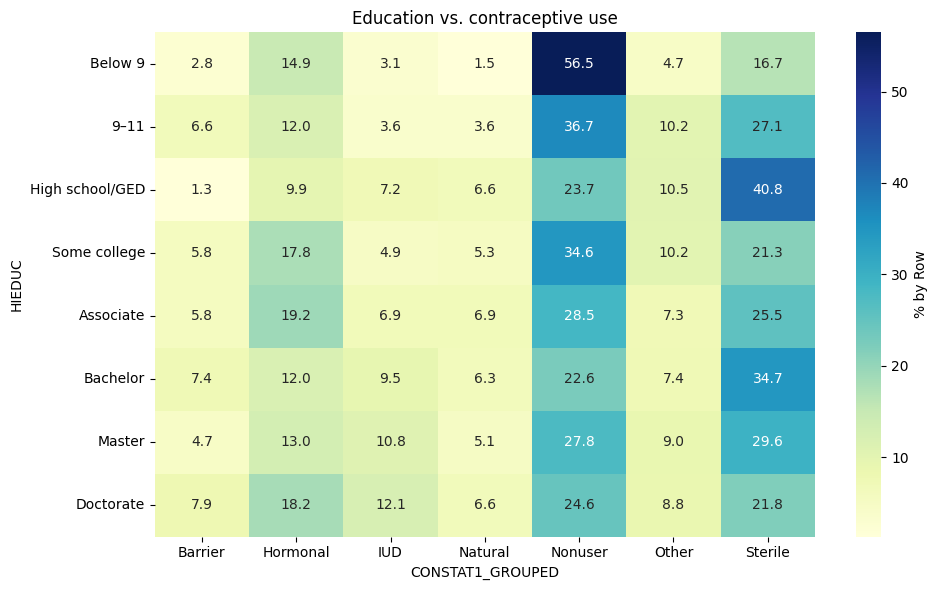

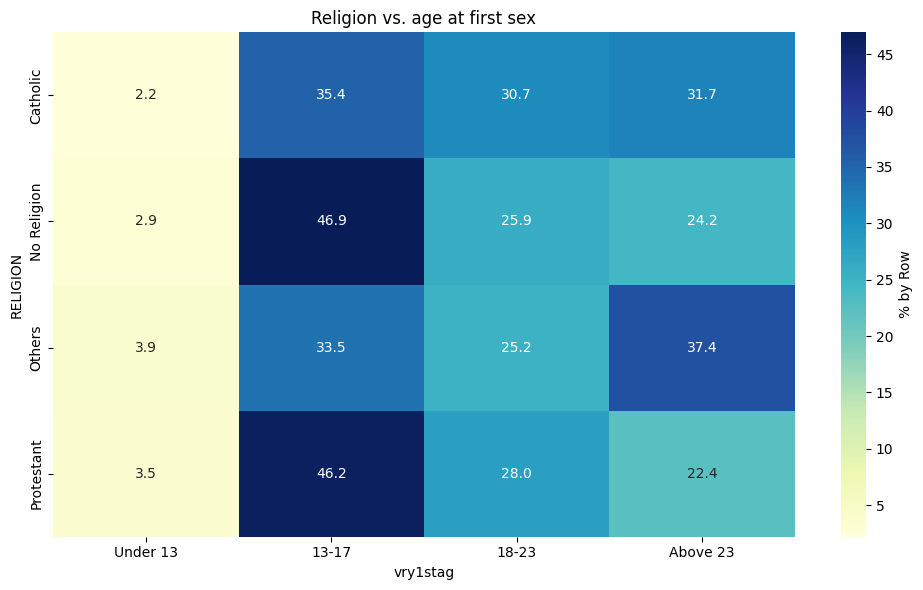

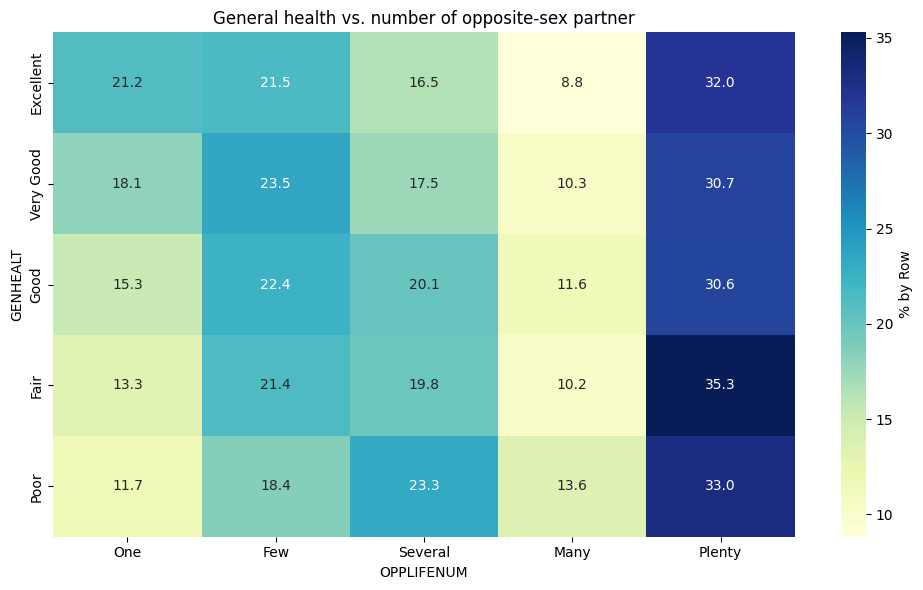

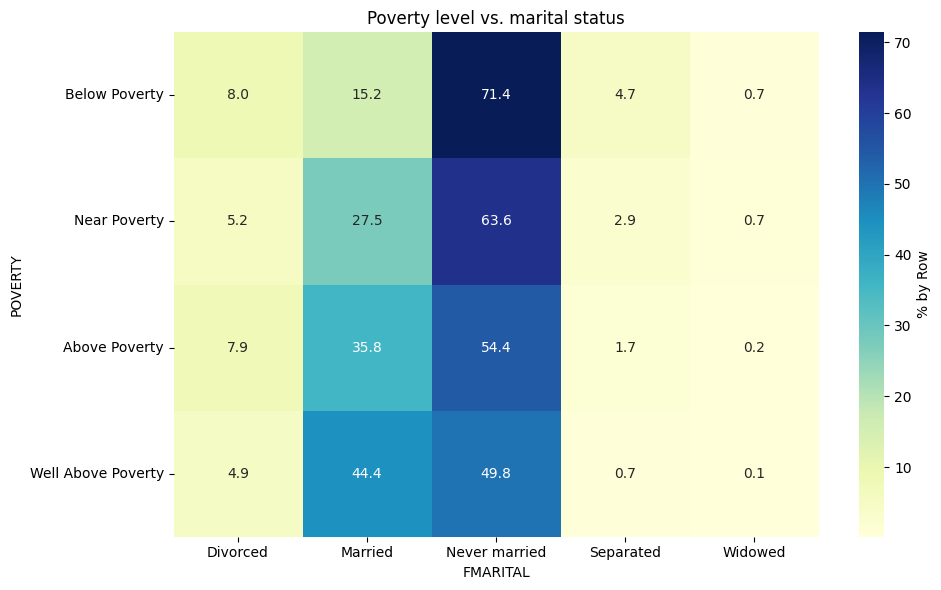

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

pairs = [
    ('HIEDUC', 'CONSTAT1_GROUPED'),
    ('RELIGION', 'vry1stag'),
    ('GENHEALT', 'OPPLIFENUM'),
    ('POVERTY', 'FMARITAL')
]

titles = [
    'Education vs. contraceptive use',
    'Religion vs. age at first sex',
    'General health vs. number of opposite-sex partner',
    'Poverty level vs. marital status'
]

for i, (var1, var2) in enumerate(pairs):
    plt.figure(figsize=(10, 6))
    crosstab = pd.crosstab(df_cleaned[var1], df_cleaned[var2], normalize='index') * 100
    sns.heatmap(crosstab, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': '% by Row'})
    plt.title(titles[i])
    plt.ylabel(var1)
    plt.xlabel(var2)
    plt.tight_layout()

    # Sanitize title to create a safe filename
    safe_title = re.sub(r'[^\w\s-]', '', titles[i]).replace(" ", "_").lower()
    filename = f"{safe_title}.png"
    plt.savefig(filename, dpi=300)
    
    plt.show()


---
# Ordinal Logistic Regression
#### One-hot encoding

In [ ]:
df_ordinal_log_reg = df_cleaned.copy()

# One-hot encode nominal variables
df_ordinal_log_reg = pd.get_dummies(df_ordinal_log_reg, columns=['RELIGION', 'INTCTFAM', 'FMARITAL', 'CONSTAT1_GROUPED'], drop_first=True)

# Ordinal encoding
ordinal_cols = {
    'OPPLIFENUM': ['One', 'Few', 'Several', 'Many', 'Plenty'],
    'GENHEALT': ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'],
    'vry1stag': ['Under 13', '13-17', '18-23', 'Above 23'],
    'AGE_R': ['15-17', '18-23', '24-35', 'Above 35'],
    'HIEDUC': ['Below 9', '9–11', 'High school/GED', 'Some college', 'Associate', 'Bachelor', 'Master', 'Doctorate'],
    'POVERTY': ['Below Poverty', 'Near Poverty', 'Above Poverty', 'Well Above Poverty'],
}

for col, order in ordinal_cols.items():
    df_ordinal_log_reg[col] = pd.Categorical(df_ordinal_log_reg[col], categories=order, ordered=True)
    df_ordinal_log_reg[col] = df_ordinal_log_reg[col].cat.codes

### X and Y

In [ ]:
# Define X and y
y = pd.Categorical(df_ordinal_log_reg['OPPLIFENUM'], ordered=True)
X = df_ordinal_log_reg.drop(columns=['OPPLIFENUM'])
X = X.astype({col: 'int' for col in X.columns if X[col].dtype == 'bool'})

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Model fitting
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Create DataFrame
fit_df = pd.DataFrame({
    'Metric': ['Log-Likelihood', 'AIC', 'Converged'],
    'Value': [result.llf, result.aic, result.mle_retvals['converged']]
})

# Data Frame
fit_df

Optimization terminated successfully.
         Current function value: 1.470531
         Iterations: 109
         Function evaluations: 111
         Gradient evaluations: 111


,Metric,Value
0,Log-Likelihood,-6696.79871
1,AIC,13439.597419
2,Converged,True


#### Interpretation
* **Log-Likelihood**
  * The model has a log-likelihood of -6696.8, which indicates an acceptable fit for ordinal logistic regression on social data.
* **AIC (Akaike Information Criterion)**
  * The AIC value of 13,440 suggests a balance between model fit and simplicity. This can be used for comparison if multiple models are tested.
* **Convergence**
  * The model converged successfully, indicating the estimated parameters are statistically reliable.

In [ ]:
# Extract odds ratios and confidence intervals
odds_ratios = np.exp(result.params)
conf_int = np.exp(result.conf_int())
coefficients = result.params
p_values = result.pvalues

# Create DataFrame
or_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios,
    'CI Lower (95%)': conf_int[0],
    'CI Upper (95%)': conf_int[1],
    'p-value': p_values
})

# Drop cutpoints (e.g., '0/1', '1/2', etc.)
or_df = or_df[~or_df.index.str.contains(r'^\d+/\d+$')]
or_df

,Coefficient,Odds Ratio,CI Lower (95%),CI Upper (95%),p-value
AGE_R,-0.165110,0.847800,0.783705,0.917138,3.846385e-05
HIEDUC,-0.028148,0.972245,0.945658,0.999578,4.661600e-02
POVERTY,0.086903,1.090791,1.034576,1.150062,1.286083e-03
vry1stag,0.211503,1.235534,1.149587,1.327907,8.952375e-09
GENHEALT,0.099107,1.104184,1.045200,1.166497,4.027464e-04
RELIGION_No Religion,0.507521,1.661168,1.417341,1.946941,3.694130e-10
RELIGION_Others,0.154429,1.166992,0.933590,1.458746,1.749735e-01
RELIGION_Protestant,0.349327,1.418113,1.215232,1.654865,9.224154e-06
INTCTFAM_Had two parents,-0.250334,0.778541,0.692835,0.874849,2.589265e-05
FMARITAL_Married,-1.019873,0.360641,0.290479,0.447750,2.484202e-20


#### Interpretation
* **AGE_R** (Age)
    * For each increase in age group, the odds of being in a higher category of opposite-sex partners decrease by 15.2%.
    * Older respondents are less likely to report more partners.
* **HIEDUC** (Education Level)
    * Not statistically significant at 0.05 (p = 0.047 borderline).
    * Slight negative effect: more education may be associated with fewer partners, but this effect is weak.
* **POVERTY** (Poverty Level)
    * For each increase in poverty level, the odds of reporting more partners increase by 9.1%.
    * Suggests possible link between economic status and sexual behavior.
* **vry1stag** (Age at First Sex)
    * Each increase in age group of first sex increases odds of more partners by 23.6%.
    * This seems counterintuitive — may reflect categorization. Possibly, “older first sex” may cluster with specific behaviors later.
* **GENHEALT** (General Health)
    * Better general health is associated with 10.4% higher odds of reporting more partners.
* **RELIGION**
    * **No Religion**: 66% higher odds of having more partners than Catholics (baseline).
    * **Protestant**: 41.8% higher odds.
* **INTCTFAM_Had two parents** (Had two parents)
    * Individuals from two-parent households are 22.2% less likely to report higher partner counts.
* **FMARITAL** (Marital Status)
    * **Married**: 64% lower odds of more partners.
    * **Never married**: 33% lower odds
    * **Separated/Widowed**: Even lower odds, suggesting marital status strongly predicts behavior.
* **CONSTAT1_GROUPED**
    * **Hormonal**: Users are 68% more likely to be in higher categories
    * **IUD**: Double the odds of reporting more partners
    * **Natural**: Strong positive association
    * **Nonuser**: Very strong predictor of high partner count
    * **Other**: Similar to hormonal methods
    * **Sterile**: Strong positive odds

#### Summary
The ordinal logistic regression model significantly predicts the number of opposite-sex partners based on variables such as age, poverty level, marital status, religion, and contraceptive method. For example, individuals using IUDs had 2.0 times higher odds of reporting more partners compared to the baseline group. Nonusers had 3.4 times higher odds. Additionally, being older, married, or from a two-parent household decreased the likelihood of reporting higher partner counts. The model converged successfully, and fit statistics (AIC = 13,440) indicate acceptable performance for social science data.

###  Multinomial Logistic Regression
#### Encoding

In [ ]:
df_multi_log_reg = df_cleaned.copy()

# One-hot encode nominal variables
df_multi_log_reg = pd.get_dummies(df_multi_log_reg, columns=['RELIGION', 'INTCTFAM', 'FMARITAL'], drop_first=True)

# Ordinal encoding
ordinal_cols = {
    'OPPLIFENUM': ['One', 'Few', 'Several', 'Many', 'Plenty'],
    'GENHEALT': ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'],
    'vry1stag': ['Under 13', '13-17', '18-23', 'Above 23'],
    'AGE_R': ['15-17', '18-23', '24-35', 'Above 35'],
    'HIEDUC': ['Below 9', '9–11', 'High school/GED', 'Some college', 'Associate', 'Bachelor', 'Master', 'Doctorate'],
    'POVERTY': ['Below Poverty', 'Near Poverty', 'Above Poverty', 'Well Above Poverty'],
}

for col, order in ordinal_cols.items():
    df_multi_log_reg[col] = pd.Categorical(df_multi_log_reg[col], categories=order, ordered=True)
    df_multi_log_reg[col] = df_multi_log_reg[col].cat.codes

In [ ]:
from statsmodels.tools import add_constant

# Define X and y
y = pd.Categorical(df_multi_log_reg['CONSTAT1_GROUPED'])
X = df_multi_log_reg.drop(columns=['CONSTAT1_GROUPED'])

# Convert all bool predictors to int
X = X.astype({col: 'int' for col in X.columns if X[col].dtype == 'bool'})

# Add constant for intercept
X = add_constant(X)

In [ ]:
import statsmodels.api as sm

# Model Fitting
model = sm.MNLogit(y, X)
result = model.fit(method='bfgs', maxiter=500)

result.summary()

Optimization terminated successfully.
         Current function value: 1.506019
         Iterations: 459
         Function evaluations: 462
         Gradient evaluations: 462


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 4554
Model:                        MNLogit   Df Residuals:                     4464
Method:                           MLE   Df Model:                           84
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.1325
Time:                        16:49:57   Log-Likelihood:                -6858.4
converged:                       True   LL-Null:                       -7905.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
              y=Hormonal       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.1365      0.516      2.203      0.028       0.125       2.148
AGE_R                       -0.2363      0.106     -2.222      0.026      -0.445      -0.028
HIEDUC                      -0.0340      0.039     -0.880      0.379      -0.110       0.042
POVERTY                      0.2443      0.072      3.387      0.001       0.103       0.386
vry1stag                    -0.0279      0.096     -0.291      0.771      -0.216       0.160
GENHEALT                     0.1413      0.077      1.830      0.067      -0.010       0.293
OPPLIFENUM                   0.1913      0.055      3.501      0.000       0.084       0.298
RELIGION_No Religion        -0.1386      0.222     -0.625      0.532      -0.574       0.296
RELIGION_Others             -0.6629      0.298     -2.221      0.026      -1.248      -0.078
RELIGION_Protestant         -0.3152      0.215     -1.465      0.143      -0.737       0.107
INTCTFAM_Had two parents     0.1081      0.163      0.663      0.508      -0.212       0.428
FMARITAL_Married            -0.8007      0.371     -2.158      0.031      -1.528      -0.073
FMARITAL_Never married       0.0648      0.371      0.175      0.861      -0.662       0.792
FMARITAL_Separated           0.2990      0.747      0.400      0.689      -1.166       1.764
FMARITAL_Widowed             4.3346     14.359      0.302      0.763     -23.808      32.477
--------------------------------------------------------------------------------------------
                   y=IUD       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.1405      0.585     -1.949      0.051      -2.288       0.007
AGE_R                        0.2818      0.124      2.267      0.023       0.038       0.525
HIEDUC                       0.0532      0.045      1.176      0.239      -0.035       0.142
POVERTY                      0.1723      0.083      2.067      0.039       0.009       0.336
vry1stag                    -0.1533      0.111     -1.383      0.167      -0.370       0.064
GENHEALT                     0.2168      0.088      2.475      0.013       0.045       0.388
OPPLIFENUM                   0.2702      0.062      4.326      0.000       0.148       0.393
RELIGION_No Religion         0.1294      0.252      0.514      0.607      -0.364       0.623
RELIGION_Others             -0.2699      0.334     -0.808      0.419      -0.925       0.385
RELIGION_Protestant         -0.3931      0.250     -1.575      0.115      -0.882       0.096
INTCTFAM_Had two parents     0.1679      0.187      0.897      0.370      -0.199       0.535
FMARITAL_Married            -0.4669      0.387     -1.207      0.228      -1.225       0.291
FMARITAL_Never married      -0.1619      0.391     -0.414      0.679      -0.928       0.604
FMARITAL_Separated           0.3242      0.790      0.411      0.681      -1.22

In [ ]:
# ---- Model Fit Summary ----
fit_summary = pd.DataFrame({
    'Metric': ['Log-Likelihood', 'AIC', 'Converged'],
    'Value': [result.llf, result.aic, result.mle_retvals['converged']]
})

fit_summary

,Metric,Value
0,Log-Likelihood,-6858.41159
1,AIC,13896.82318
2,Converged,True
